# Ultra-fast categorization of image containing animals *in vivo* and *in computo*

Hi! I am  [Jean-Nicolas Jérémie](https://github.com/JNJER) in this notebook, I will use the [Pytorch](https://pytorch.org/) library to run the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook focused on the training and the test of Deep convolutional neuronal networks (DCNNs) for ecological tasks such as detecting an animal in a natural scene.

I uses transfer learning to train the DCNN, starting from a VGG16 network, taken from the `torchvision.models` library, pre-trained on the [Imagenet](http://image-net.org/) dataset which allows to perform label detection on naturals images for $K = 1000$ labels. Then re-train the whole network to perfom the same task but in a sub-set of $K = 1$ synset from the Imagenet dataset. The dataset I used here to train the networks is not multilabel (as we have the information about the occurence of only one synset on the scene), in order to train networks on independant task I choose to limit the output of the DCNN to $K = 1$ synset. 

In this notebook I test a pruning protocol where I progressively remove layers from a pre-trained VGG network. The network named vgg-1 has his last convolutional layer pruned, then I applied the same training process used for the VGG Gen network (see `UltraFastCat.ipynb`) with the dataset where the targets are animals. This protocol includes $12$ different deepness factors (from vgg-1 to vgg-12).

The first part consist of the training of the networks and an analysis of various training parameters. Finally the last part of this notebook is dedicated to the test of the robustness of the resulted networks while appliying various geometric tranformations to the input or by varying the subjective complexity of the synset ('animal', 'birds', 'dog', 'cat...) 

This notebook was done during my thesis at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2022-03_UltraFastCat).

## Bibliography : Todo

In [1]:
%matplotlib inline
%mkdir -p Prunning

# Trainning process

And finnaly, experiment_train.py, a pretty classic trainning script with pytorch. For further statistical analyses, we extract factors (like the accuracy and loss) in a `pandas` object. 

In [2]:
scriptname = 'Prunning/experiment_train.py'

In [3]:
%%writefile {scriptname}
from src.model import *
from Prunning.vgg_maker import *
def train_model(model, num_epochs, dataloaders, lr=args.lr, momentum=args.momentum, beta2=args.beta2, log_interval=100, **kwargs):
    
    model.to(device)
    if beta2 > 0.: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(momentum, beta2)) #, amsgrad=amsgrad)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # to set training variables

    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val', 'device_type']) 

    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs[:,0], labels.float())

            loss.backward()
            optimizer.step()

            loss_train += loss.item() * images.size(0)
            preds = torch.round(torch.sigmoid(outputs[:,0].data))
            acc_train += torch.sum(preds == labels.data)
            
        avg_loss = loss_train / dataset_sizes[task]['train']
        avg_acc = acc_train / dataset_sizes[task]['train']
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs[:,0], labels.float())

                loss_val += loss.item() * images.size(0)
                preds = torch.round(torch.sigmoid(outputs[:,0].data))
                acc_val += torch.sum(preds == labels.data)
        
            avg_loss_val = loss_val / dataset_sizes[task]['val']
            avg_acc_val = acc_val / dataset_sizes[task]['val']
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':float(avg_acc),
                               'avg_loss_val':avg_loss_val, 'avg_acc_val':float(avg_acc_val), 'device_type':device.type}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")

    model.cpu()
    torch.cuda.empty_cache()
    return model, df_train

# https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451
criterion = nn.BCEWithLogitsLoss() #binary_cross_entropy_with_logits

# Training and saving the network

n_output = 1
len_pruning = 10

# Downloading the model
model_filenames = {}
models_vgg = {}

models_vgg['VGG_Gen'] = torchvision.models.vgg16(pretrained=True)  
num_features = models_vgg['VGG_Gen'].classifier[-1].in_features
features = list(models_vgg['VGG_Gen'].classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, n_output)]) # Add our layer with 10 outputs
models_vgg['VGG_Gen'].classifier = nn.Sequential(*features) # Replace the model classifier

  

task = 'animal'
model_filenames['VGG_Gen'] =  args.model_path + "vgg16_gen_"+ task + ".pt"

m = 0
input_lin_1 = 12544
vgg_head = torchvision.models.vgg16(pretrained=True)
all_models = ['vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']
goal =  list(vgg_head.features.children())
for model_name in all_models:
    model_filenames[model_name] = str(args.model_path +model_name+'.pt')
    models_vgg[model_name] = torchvision.models.vgg16(pretrained=True)
    if len(goal) > 28 :
        del goal[24:26] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal) #get the new features parameters in the model
    elif len(goal) > 26:
        del goal[24:26] # remove the three last Conv2d and ReLU layers
        del goal[-1] # remove the last MaxPool2d layer when no Conv2d or ReLU layer left
        models_vgg[model_name].features = torch.nn.Sequential(*goal) 
    elif len(goal) > 20: # same as above for the next three Conv2d and ReLU layers
        del goal[19:21] 
        models_vgg[model_name].features = torch.nn.Sequential(*goal) 
    elif len(goal) > 17:
        del goal[17:19] # remove the three last Conv2d and ReLU layers
        del goal[-1] # remove the last MaxPool2d layer when no Conv2d or ReLU layer left
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal) > 13:
        del goal[11:13] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal) > 10:
        del goal[10:12] # remove the three last Conv2d and ReLU layers
        del goal[-1] # remove the last MaxPool2d layer when no Conv2d or ReLU layer left
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal)>9:
        del goal[6:8] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal)>7:
        del goal[3:6] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    else:
        del goal[2:4] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
        
        
    if model_name in ['vgg-6','vgg-7','vgg-8']:   
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-9','vgg-10']:
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//2, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-11','vgg-12']:
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//4, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1

    else : 
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier     
        m += 1
#models_vgg['VGG_Test'] = torchvision.models.vgg16(pretrained=False)     # Test why VGG_maker fail... conv part +++
#models_vgg['VGG_Test'].features = models_vgg['vgg-6'].features 
#models_vgg['VGG_Test'].classifier = vgg16_classifier(pretrained= False, deepness = "5").classifier
#model_filenames['VGG_Test'] =  args.model_path + "vgg_test.pt"  

    model_filenames[model_name] = str(args.model_path +model_name+"_"+ task +'.pt') # Uncomment to load dog models

for model_name in models_vgg:
    if os.path.isfile(model_filenames[model_name]):
        print("Loading pretrained model for..", model_name, ' from', model_filenames[model_name])
        #print("Resume_training : ", resume_training)

        if device.type == 'cuda':
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name])) #on GPU
        else:
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name], map_location=torch.device('cpu'))) #on CPU
    else :
        p = 0
        filename = f'results/{datetag}_{HOST}_train_{model_name}.json'
        print("Re-training pretrained model...", model_filenames[model_name])
        since = time.time()
        print(f"Traning {model_name}, image_size = {args.image_size}, p (Grayscale) = {p}")
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=p)
        models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                    dataloaders=dataloaders[task])
        torch.save(models_vgg[model_name].state_dict(), model_filenames[model_name])
        df_train.to_json(filename)
        elapsed_time = time.time() - since
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
        print()


Overwriting Prunning/experiment_train.py


In [4]:
%run {scriptname}

Creating file results/2022-05-17_config_args.json
On date 2022-05-17 , Running benchmark on host neo-ope-de04  with device cuda
-----------------------------
List of Pre-selected tasks : 
-----------------------------
398  Targets for the task : animal
602  Distractors for the task : animal
------
animal
------
Loaded 1200 images under test
Loaded 800 images under val
Loaded 2000 images under train


ModuleNotFoundError: No module named 'Prunning.vgg_maker'

## Average accuracy and loss

Here we display both average accuracy and loss during the training phase and during the validation one : 

In [5]:
datetag = '2022-01-07'
for model_name in all_models:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    if os.path.isfile(filename):
        df_train = pd.read_json(filename)
        fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
        ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
        ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
        ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
        ax.set_xlabel("Epoch", size=18)
        ax.spines['left'].set_position(('axes', -0.01))
        ax.set_xlim(-0.5, args.num_epochs)
        ax.grid(which='both')
        for side in ['top', 'right'] :ax.spines[side].set_visible(False)
        ax.set_ylim(0., 1.1)
        axs.set_title(f'Average values of the loss by epoch : {filename}' , size = 20)
        ax.get_legend().remove()
        fig.legend(bbox_to_anchor=(1.05, .5), loc='lower right', fontsize = 20)
    else:
        print('no such files')

NameError: name 'all_models' is not defined

In [6]:
for model_name in all_models:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    if os.path.isfile(filename):
        df_train = pd.read_json(filename)
        fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
        ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
        ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
        ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);
        ax.set_xlabel("Epoch", size=18)
        ax.spines['left'].set_position(('axes', -0.01))
        #ax.set_ylim(0.70, .992)
        ax.set_yscale("logit", one_half="1/2", use_overline=True)
        ax.grid(which='both')
        ax.set_xlim(-0.5, args.num_epochs+.5)
        for side in ['top', 'right'] :ax.spines[side].set_visible(False)
        axs.set_title(f'Average values of the accuracy by epoch : {filename}' , size = 20)
        ax.get_legend().remove()
        fig.legend(bbox_to_anchor=(1.05, .5), loc='lower right', fontsize=20)
    else:
        print('no such file')

NameError: name 'all_models' is not defined

## TODO Bonus: Scan of some parameters

In [7]:
scriptname = 'experiment_scan.py'

In [8]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_transfer_learning.model import *

scan_dicts= {'batch_size' : [8, 13, 21, 34, 55],
             'lr': args.lr * np.logspace(-1, 1, 7, base=10),
             'momentum': 1 - np.logspace(-3, -.5, 7, base=10),
             'beta2': 1 - np.logspace(-5, -1, 7, base=10),
            }

def main(N_avg=10, num_epochs=args.num_epochs//4):
    from experiment_train import train_model

    for key in scan_dicts:
        filename = f'results/{datetag}_train_scan_{key}_{args.HOST}.json'
        print(f'{filename=}')
        if os.path.isfile(filename):
            df_scan = pd.read_json(filename)
        else:
            i_trial = 0
            measure_columns = [key, 'avg_loss_val', 'avg_acc_val', 'time']

            df_scan = pd.DataFrame([], columns=measure_columns) 
            for i_trial, value in enumerate(scan_dicts[key]):
                new_kwarg = {key: value}
                print('trial', i_trial, ' /', len(scan_dicts[key]))
                print('new_kwarg', new_kwarg)
                # Training and saving the network
                models_vgg_ = torchvision.models.vgg16(pretrained=True)
                # Freeze training for all layers
                # Newly created modules have require_grad=True by default
                for param in models_vgg_.features.parameters():
                    param.require_grad = False 

                num_features = models_vgg_.classifier[-1].in_features
                features = list(models_vgg_.classifier.children())[:-1] # Remove last layer
                features.extend([nn.Linear(num_features, n_output)]) # Add our layer with `n_output` outputs
                models_vgg_.classifier = nn.Sequential(*features) # Replace the model classifier

                since = time.time()

                (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=0, **new_kwarg)
                models_vgg_, df_train = train_model(models_vgg_, num_epochs=num_epochs, dataloaders=dataloaders, **new_kwarg)

                elapsed_time = time.time() - since
                print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

                df_scan.loc[i_trial] = {key:value, 'avg_loss_val':df_train.iloc[-N_avg:-1]['avg_loss_val'].mean(), 
                                   'avg_acc_val':df_train.iloc[-N_avg:-1]['avg_acc_val'].mean(), 'time':elapsed_time}
                print(df_scan.loc[i_trial])
                i_trial += 1
            df_scan.to_json(filename)

main()    

Overwriting experiment_scan.py


In [9]:
%run -int {scriptname}

ModuleNotFoundError: No module named 'DCNN_transfer_learning'


IPython CPU timings (estimated):
  User   :       0.05 s.
  System :       0.00 s.
Wall time:       0.07 s.


In [10]:
for key in scan_dicts:
    filename = f'results/{datetag}_train_scan_{key}_{args.HOST}.json'
    print(filename)
    df_scan = pd.read_json(filename)
    print(df_scan)

NameError: name 'scan_dicts' is not defined

 Here we display both average accuracy and loss during the training phase and during the validation one : 

# Testing the new networks

Now that the networks seems ready for the comparison. The second part of this notebook offers a comparison between the three re-trained version of the same network VGG16 based on a Wordnet semantic from the Imagenet database wich allows to work on naturals images for $1$ synsets. 

Since the networks need to be re-train in order to perform a categorization with fewer convolutional layers I did not compute the accuracy for the pre-trained VGG network trained on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for $1000$ labels, taken from the `torchvision.models` library in this notebook. 

<a id="exp1"></a>
## Experiment 1: Image processing and recognition for differents labels 

In [11]:
scriptname =  'Prunning/experiment_basic.py'

In [12]:
%%writefile {scriptname}

#import model's script and set the output file

from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
datetag = '2022-02-08'
filename = f'results/{datetag}_results_1_del_lay_{HOST}.json'
print(f'{filename=}')
task = 'animal'

def main():
    if os.path.isfile(filename):
        df_del_lay = pd.read_json(filename)
    else:
        i_trial = 0
        df_del_lay = pd.DataFrame([], columns=['model', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    percentage = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if percentage>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_del_lay.loc[i_trial] = {'model':model_name, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                      'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize an animal with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
    df_del_lay.to_json(filename)
main()         

Overwriting Prunning/experiment_basic.py


In [13]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

In [14]:
filename = f'results/{datetag}_results_1_del_lay_{HOST}.json'
df_del_lay = pd.read_json(filename)
df_del_lay

ValueError: Expected object or value

### Image display

I displayed the images in various conditions with the likelihood at the output of the network as the `y_label`, the label found by the network and the name of the networks as the `x_label`. If the labels are in green the categorization made by the network is correct (detect a target:'animal' in the scene when there is indeed an animal in the scene), if the labels are red the network failed the categorization. 

Here is the images with the higher likelihood of the networks : 

NameError: name 'df_del_lay' is not defined

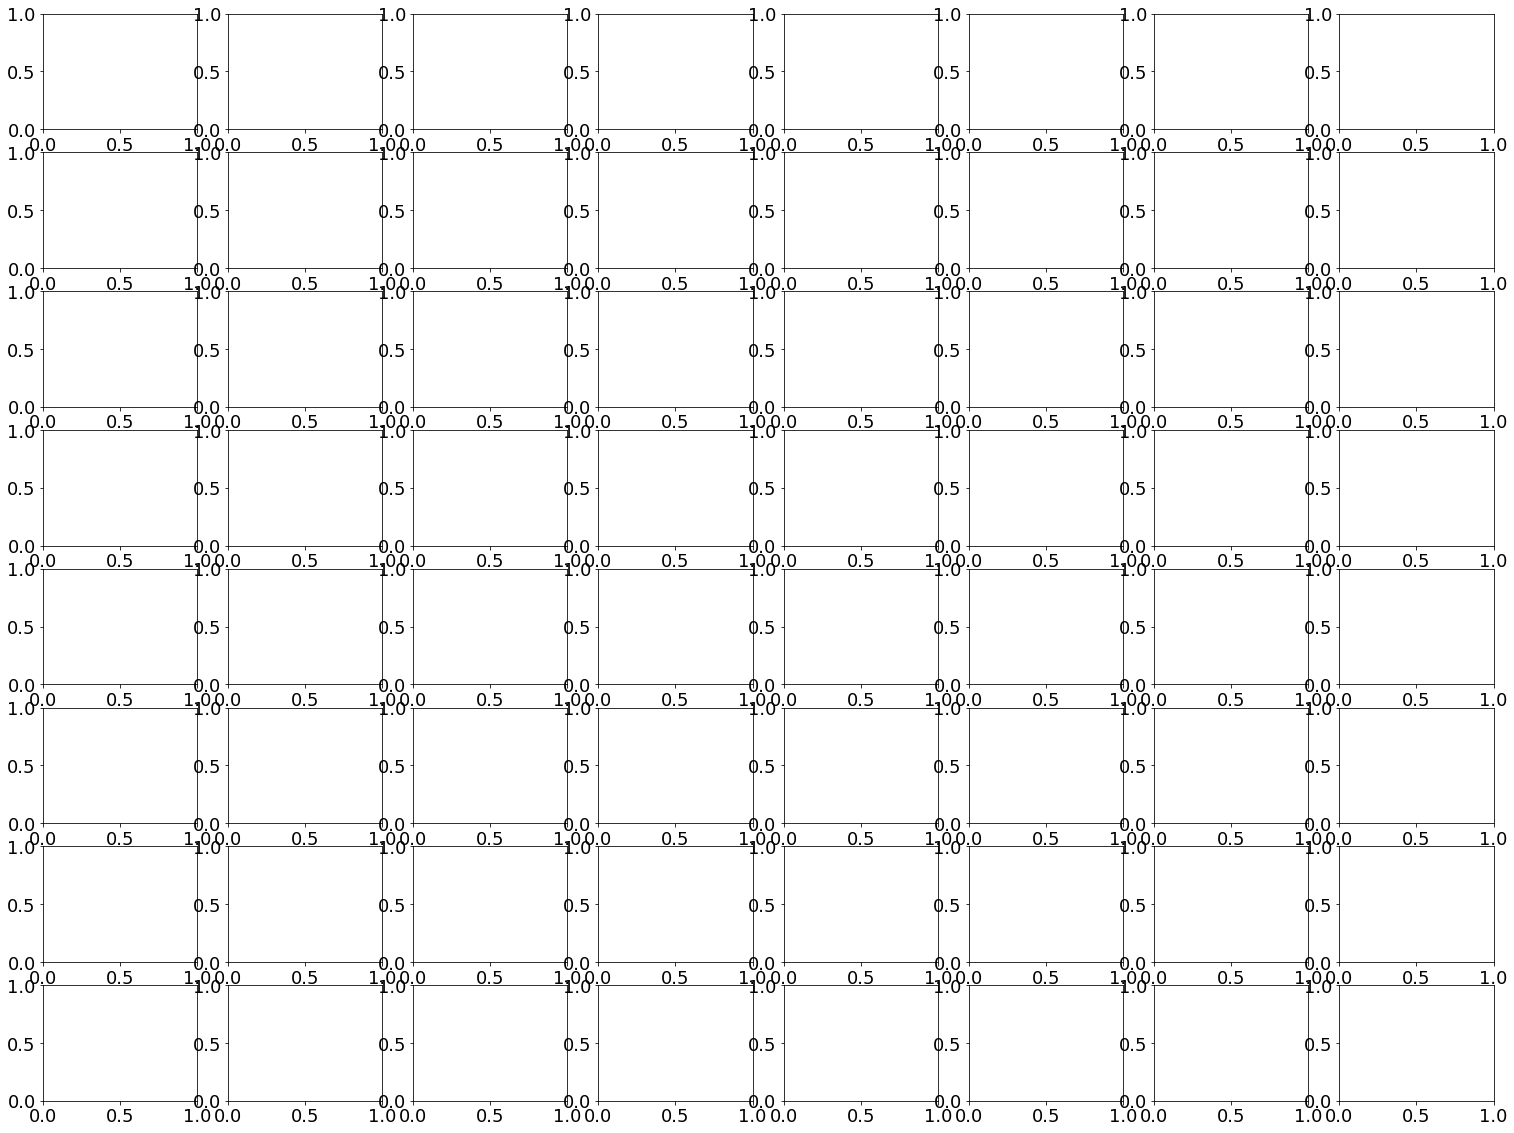

In [15]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_del_lay.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_del_lay.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_del_lay.loc[idx]['top_1'] == df_del_lay.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_del_lay.loc[idx]['top_1'] + ' | ' + df_del_lay.loc[idx]['model'], color=color)
    likelihood = df_del_lay.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'df_del_lay' is not defined

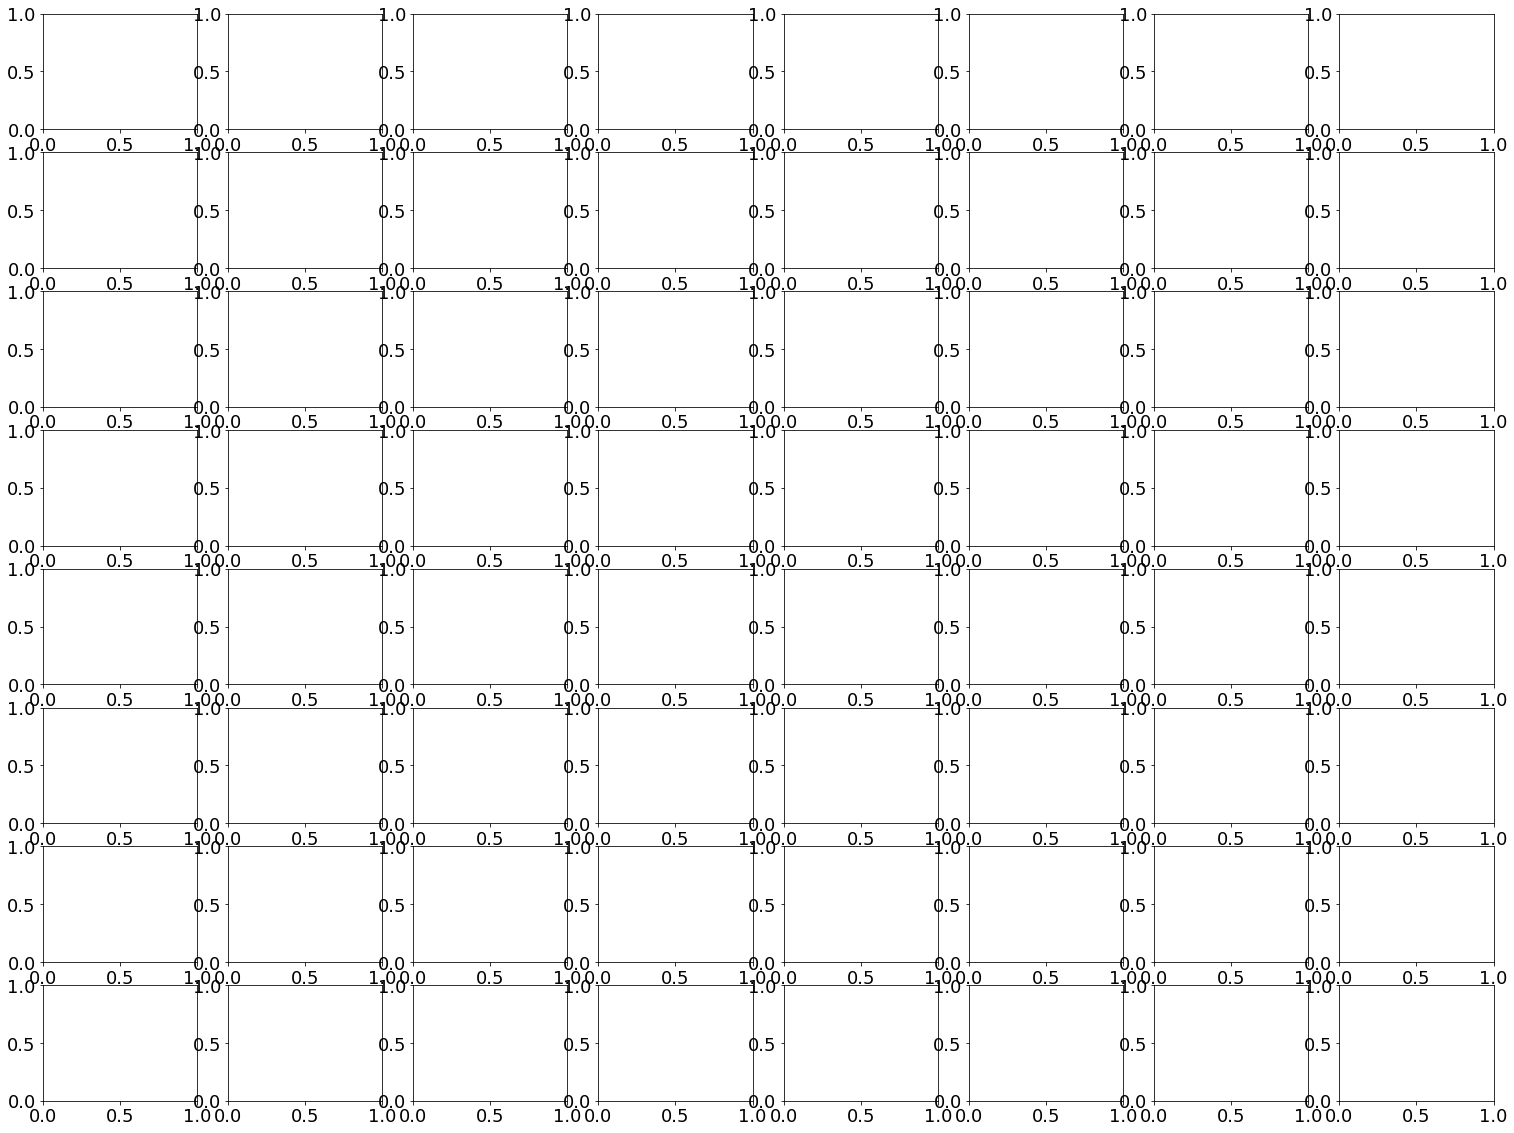

In [16]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_del_lay.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_del_lay.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_del_lay.loc[idx]['top_1'] == df_del_lay.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_del_lay.loc[idx]['top_1'] + ' | ' + df_del_lay.loc[idx]['model'], color=color)
    likelihood = df_del_lay.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)  
fig.set_facecolor(color='white')

### Accuracy

In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig_width = 15
results = []
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_del_lay['model'].unique())) for i,k in enumerate(df_del_lay['model'].unique())})
for name in models_vgg:
    results.append(f1_score(df_del_lay[df_del_lay['model']==name]["top_1"],
                            df_del_lay[df_del_lay['model']==name]["goal"],average='micro'))
df_acc = pd.DataFrame({'': results},index = models_vgg)
ax = df_acc.plot.bar(rot=30, figsize=(fig_width//1.2, fig_width//2.5), fontsize = 18, color=color_dict['vgg-6'])
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k')
ax.get_legend().remove()
plt.legend(bbox_to_anchor=(1.15, .5), loc='right')
ax.set_ylabel('Accuracy', size= 24, fontweight='bold' )
for container in ax.containers: ax.bar_label(container, padding=-50, fontsize=15.5, fmt='%.3f', rotation=90, color='black', fontweight='bold')
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold')
plt.legend()
plt.tight_layout()
#plt.savefig('IJCNN_fig.7.pdf');

NameError: name 'df_del_lay' is not defined

### Computation Time

In [18]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi/2), sharex=True, sharey=True)
for ax, model_name in zip(axs, models_vgg.keys()):
    df_del_lay[df_del_lay['model']==model_name]['time'].plot.hist(bins=350, lw=1, label=model_name,ax=ax, density=True)
    ax.set_xlim(df_del_lay['time'].quantile(.01), df_del_lay['time'].quantile(.99))
    ax.legend(bbox_to_anchor=(1.21, .35), loc='lower right', fontsize=15)
    ax.grid(which='both', axis='y')
    ax.set_xlabel('Processing time (s): ' + model_name, size=22)
axs[0].set_title('Distribution of the Processing time (s). Processed on : ' + args.HOST + '_' + str(df_del_lay['device_type'][0]), size = 20);


NameError: name 'models_vgg' is not defined

### Conclusion

We tested the pruned networks re-trained to categorize an animal in a scene on our Imagenet dataset. VGG Gen gets the best acuracy on this task, with a slight drop at vgg-1, followed by a flat phase between vgg-1 and vgg-8. Then another drop between vgg-9 and vgg-12 where the networks stands close to the chance level. The accuracies of the networks stay similar to the performances found by
[Serre & al](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf), this is not a surprise as their model relies on low level features. Note that the computing time necessary to perform the categorization decreases with the accuracy of the network ({\sc VGG Gen} = 0.005 +/- 0.0001, {\sc vgg-8} = 0.003 +/- 0.0001).

<a id="exp2"></a>
## Experiment 2: Image processing and recognition for differents resolutions :

In [19]:
scriptname = 'Prunning/experiment_downsample.py'

In [20]:
%%writefile {scriptname}

#import model's script and set the output file
from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_2_del_lay_{HOST}.json'
task = 'animal'
 

def main():
    if os.path.isfile(filename):
        df_downsample_del = pd.read_json(filename)
    else:
        i_trial = 0
        df_downsample_del = pd.DataFrame([], columns=['model','task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'image_size', 'top_1', 'device']) 
        # image preprocessing
        for image_size in args.image_sizes:
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size)
            print(f'Résolution de {image_size=}')

            # Displays the input image of the model 
            for i_image, (data, label) in enumerate(image_datasets[task]['test']):
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    model.eval()
                    tic = time.time()
                    out = model(data.unsqueeze(0).to(device)).squeeze(0)
                    percentage = (torch.sigmoid(out) * 100).detach().cpu().numpy()[0]
                    elapsed_time = time.time() - tic
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    top_1 = 'target' if percentage>50 else 'distractor'
                    df_downsample_del.loc[i_trial] = {'model':model_name, 'task':image_datasets[task]['test'].classes[label], 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                   'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'image_size': image_size, 'device':str(device)}
                    print(f'The {model_name} model categorize {task} with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')

                    i_trial += 1
    df_downsample_del.to_json(filename)
    
main()

Overwriting Prunning/experiment_downsample.py


In [21]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

<Figure size 432x288 with 0 Axes>

In [22]:
filename = f'results/{datetag}_results_2_del_lay_{HOST}.json'
df_downsample_del = pd.read_json(filename)
df_downsample_del

ValueError: Expected object or value

### Image display 

Here is the images with the highest likelihood of the networks :

NameError: name 'df_downsample_del' is not defined

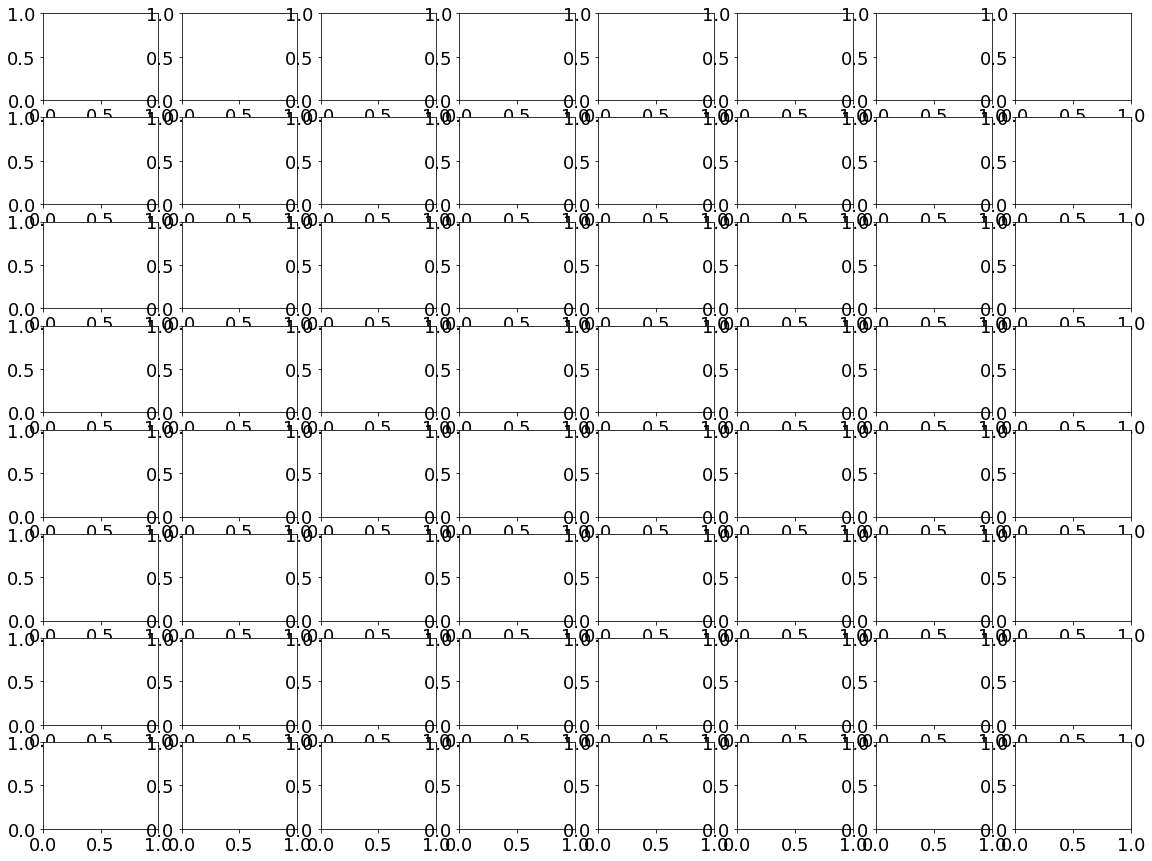

In [23]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_downsample_del.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_downsample_del.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_downsample_del.loc[idx]['top_1'] == df_downsample_del.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_downsample_del.loc[idx]['top_1'] + ' | ' + df_downsample_del.loc[idx]['model'] + ' | ' + str(df_downsample_del.loc[idx]['image_size']), color=color)
    likelihood = df_downsample_del.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'df_downsample_del' is not defined

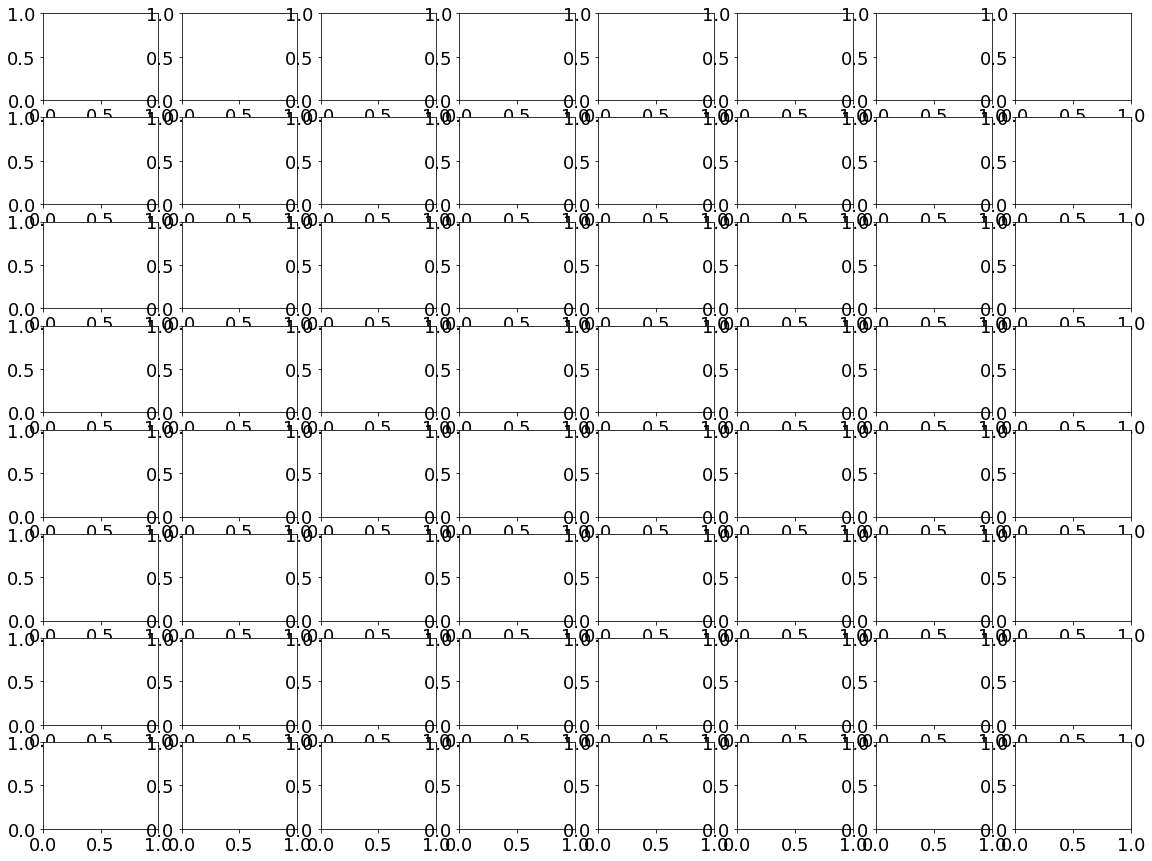

In [24]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_downsample_del.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_downsample_del.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_downsample_del.loc[idx]['top_1'] == df_downsample_del.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_downsample_del.loc[idx]['top_1'] + ' | ' + df_downsample_del.loc[idx]['model'] + ' | ' + str(df_downsample_del.loc[idx]['image_size']), color=color)
    likelihood = df_downsample_del.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)  
fig.set_facecolor(color='white')

### Accuracy

In [25]:
fig_width = 35
#names_diff = ['vgg16_gen','vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8'] 
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {image_size: accuracy_score(df_downsample_del[(df_downsample_del['model']==model_name) & (df_downsample_del['image_size']==image_size)]["top_1"], 
                                                               df_downsample_del[(df_downsample_del['model']==model_name) & (df_downsample_del['image_size']==image_size)]["goal"])
                                    for image_size in args.image_sizes} 
                       for model_name in models_vgg})

ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=30)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=18, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.05, .5), loc='center', fontsize=18)
#ax.set_title(f'Experiment 2 - image sizes = {args.image_sizes}', size=20)
ax.set_ylabel('F1 Score', size=32)
ax.set_xlabel('Image sizes', size=32)
#plt.show();
plt.savefig('del_lay_diff_size.pdf')

NameError: name 'models_vgg' is not defined

In [26]:
ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 2 - image sizes = {args.image_sizes}', size=20)
#ax.set_xticks([])
ax.set_ylabel('F1 score', size=32)
ax.set_xlabel('Models', size=32)
plt.show();

NameError: name 'df_acc' is not defined

### Computation Time

NameError: name 'models_vgg' is not defined

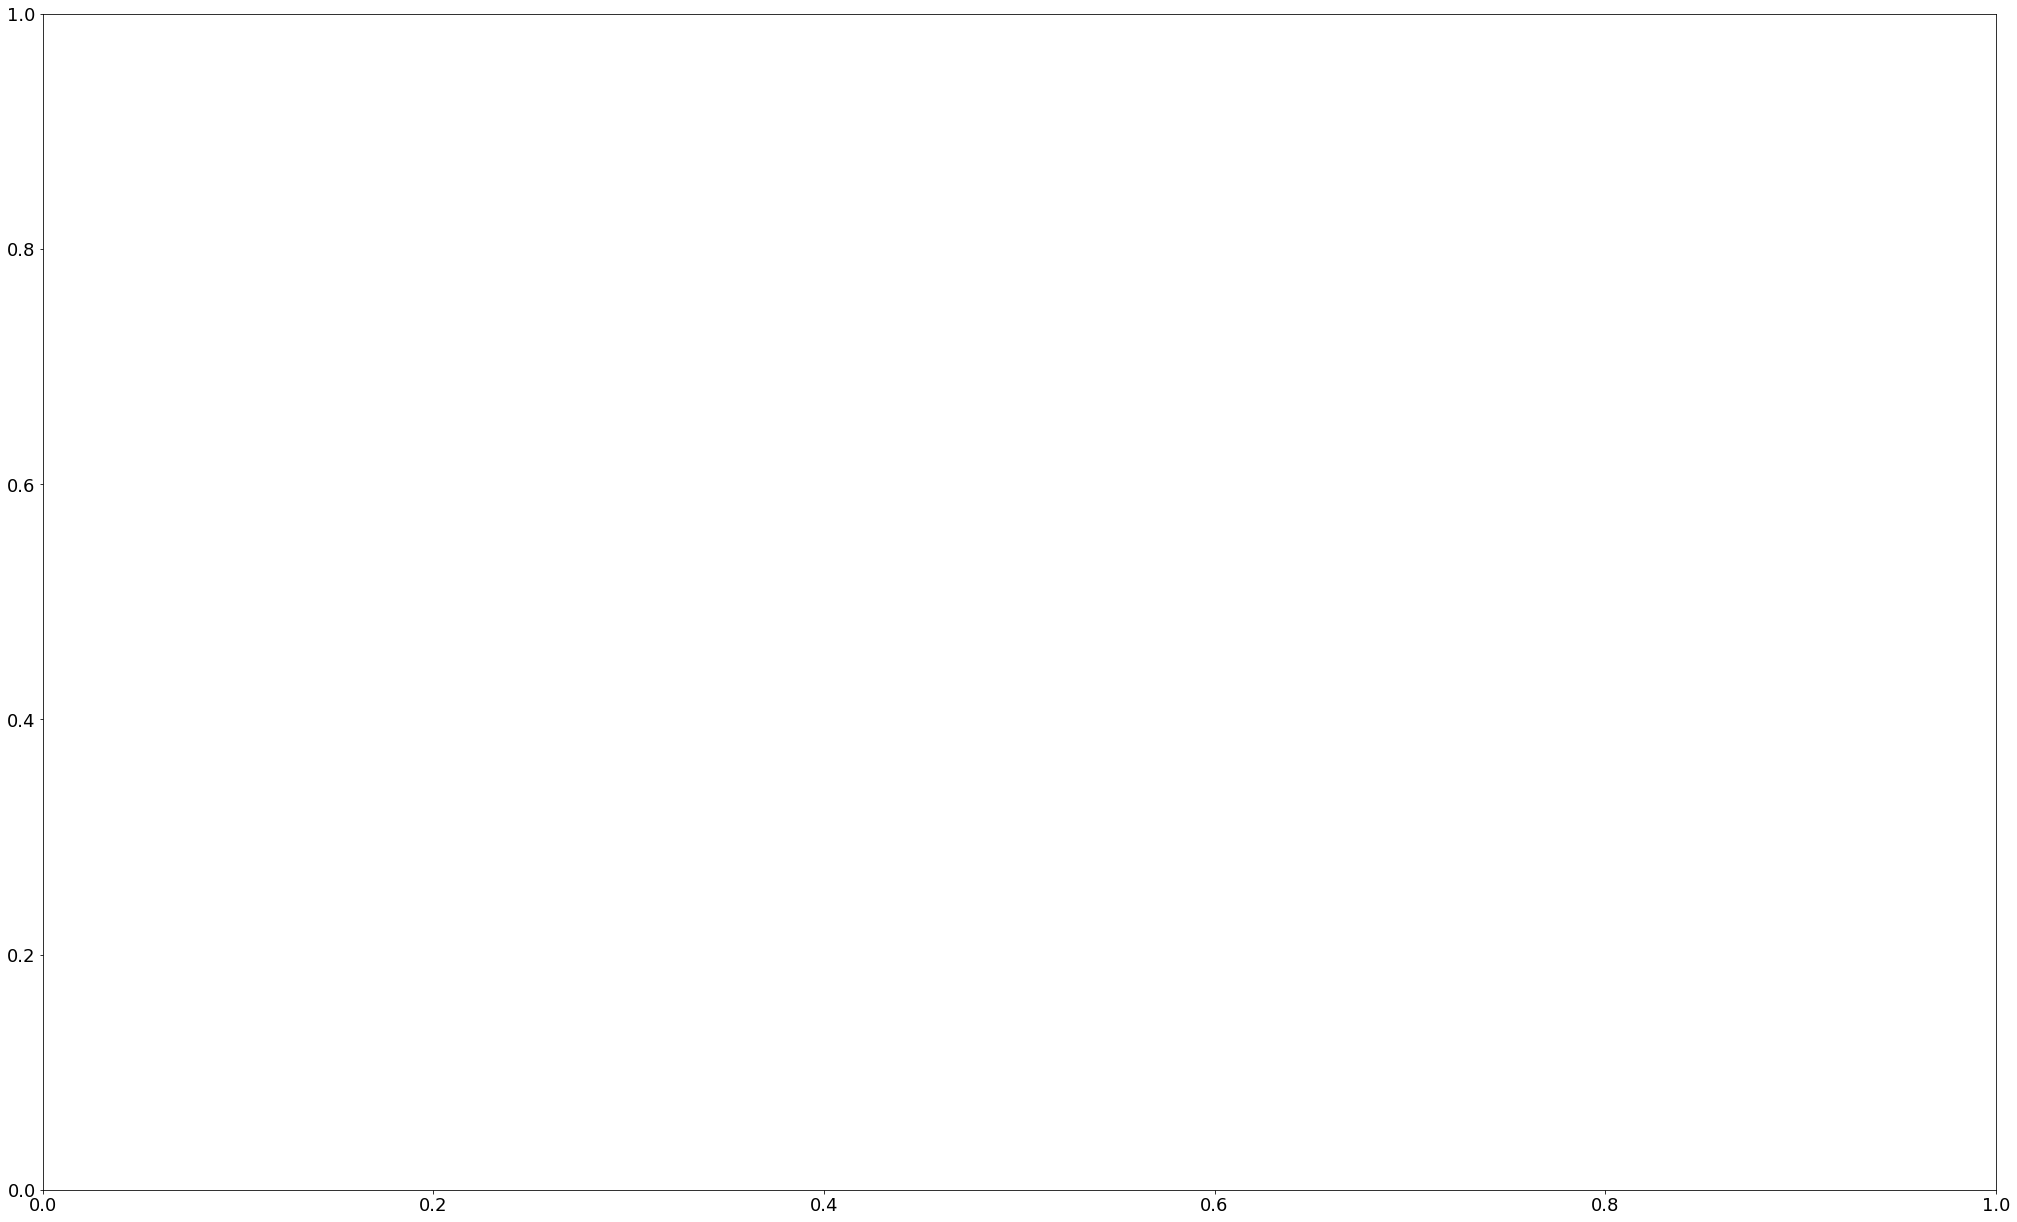

In [27]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample_del, inner="quartile", hue='model')
    axs.set_title('Processed on : ' + args.HOST + '_' + str(df_downsample_del['device'][0]), size = 20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Trial', size=18)
    axs.set_yscale('log')
    axs.grid(which='both', axis='y')
    for side in ['top', 'right'] :axs.spines[side].set_visible(False)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

### Conclusion

The categorization performance keeps relatively the same organization with the transformation as the VGG Gen stay the best networks and the VGG-12 the worst on this task. Surprisingly, the robustness of the networks does not seem to be directly related to their depth as one might expect. Shorter networks rely on lower levels of features for their categorization, so this may explains why networks like Vgg-3 are more robust to this transformation than VGG Gen even if their overall performances is not as good as VGG Gen. 

## Experiment 3: Image processing and recognition on grayscale images :

In [28]:
scriptname = 'Prunning/experiment_grayscale.py'

In [29]:
%%writefile {scriptname}

#import model's script and set the output file
from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

filename = f'results/{datetag}_results_3_del_lay_{args.HOST}.json'
print(f'{filename=}')
task = 'animal'
def main():
    if os.path.isfile(filename):
        df_gray_del_lay = pd.read_json(filename)
    else:
        i_trial = 0
        df_gray_del_lay = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1, p=1)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    percentage = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if percentage>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_gray_del_lay.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                      'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize {model_task} with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
    df_gray_del_lay.to_json(filename)
main()

Overwriting Prunning/experiment_grayscale.py


In [30]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

<Figure size 432x288 with 0 Axes>

In [31]:
filename = f'results/{datetag}_results_3_del_lay_{HOST}.json'
df_gray_del_lay = pd.read_json(filename)
df_gray_del_lay

ValueError: Expected object or value

### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'df_gray_del_lay' is not defined

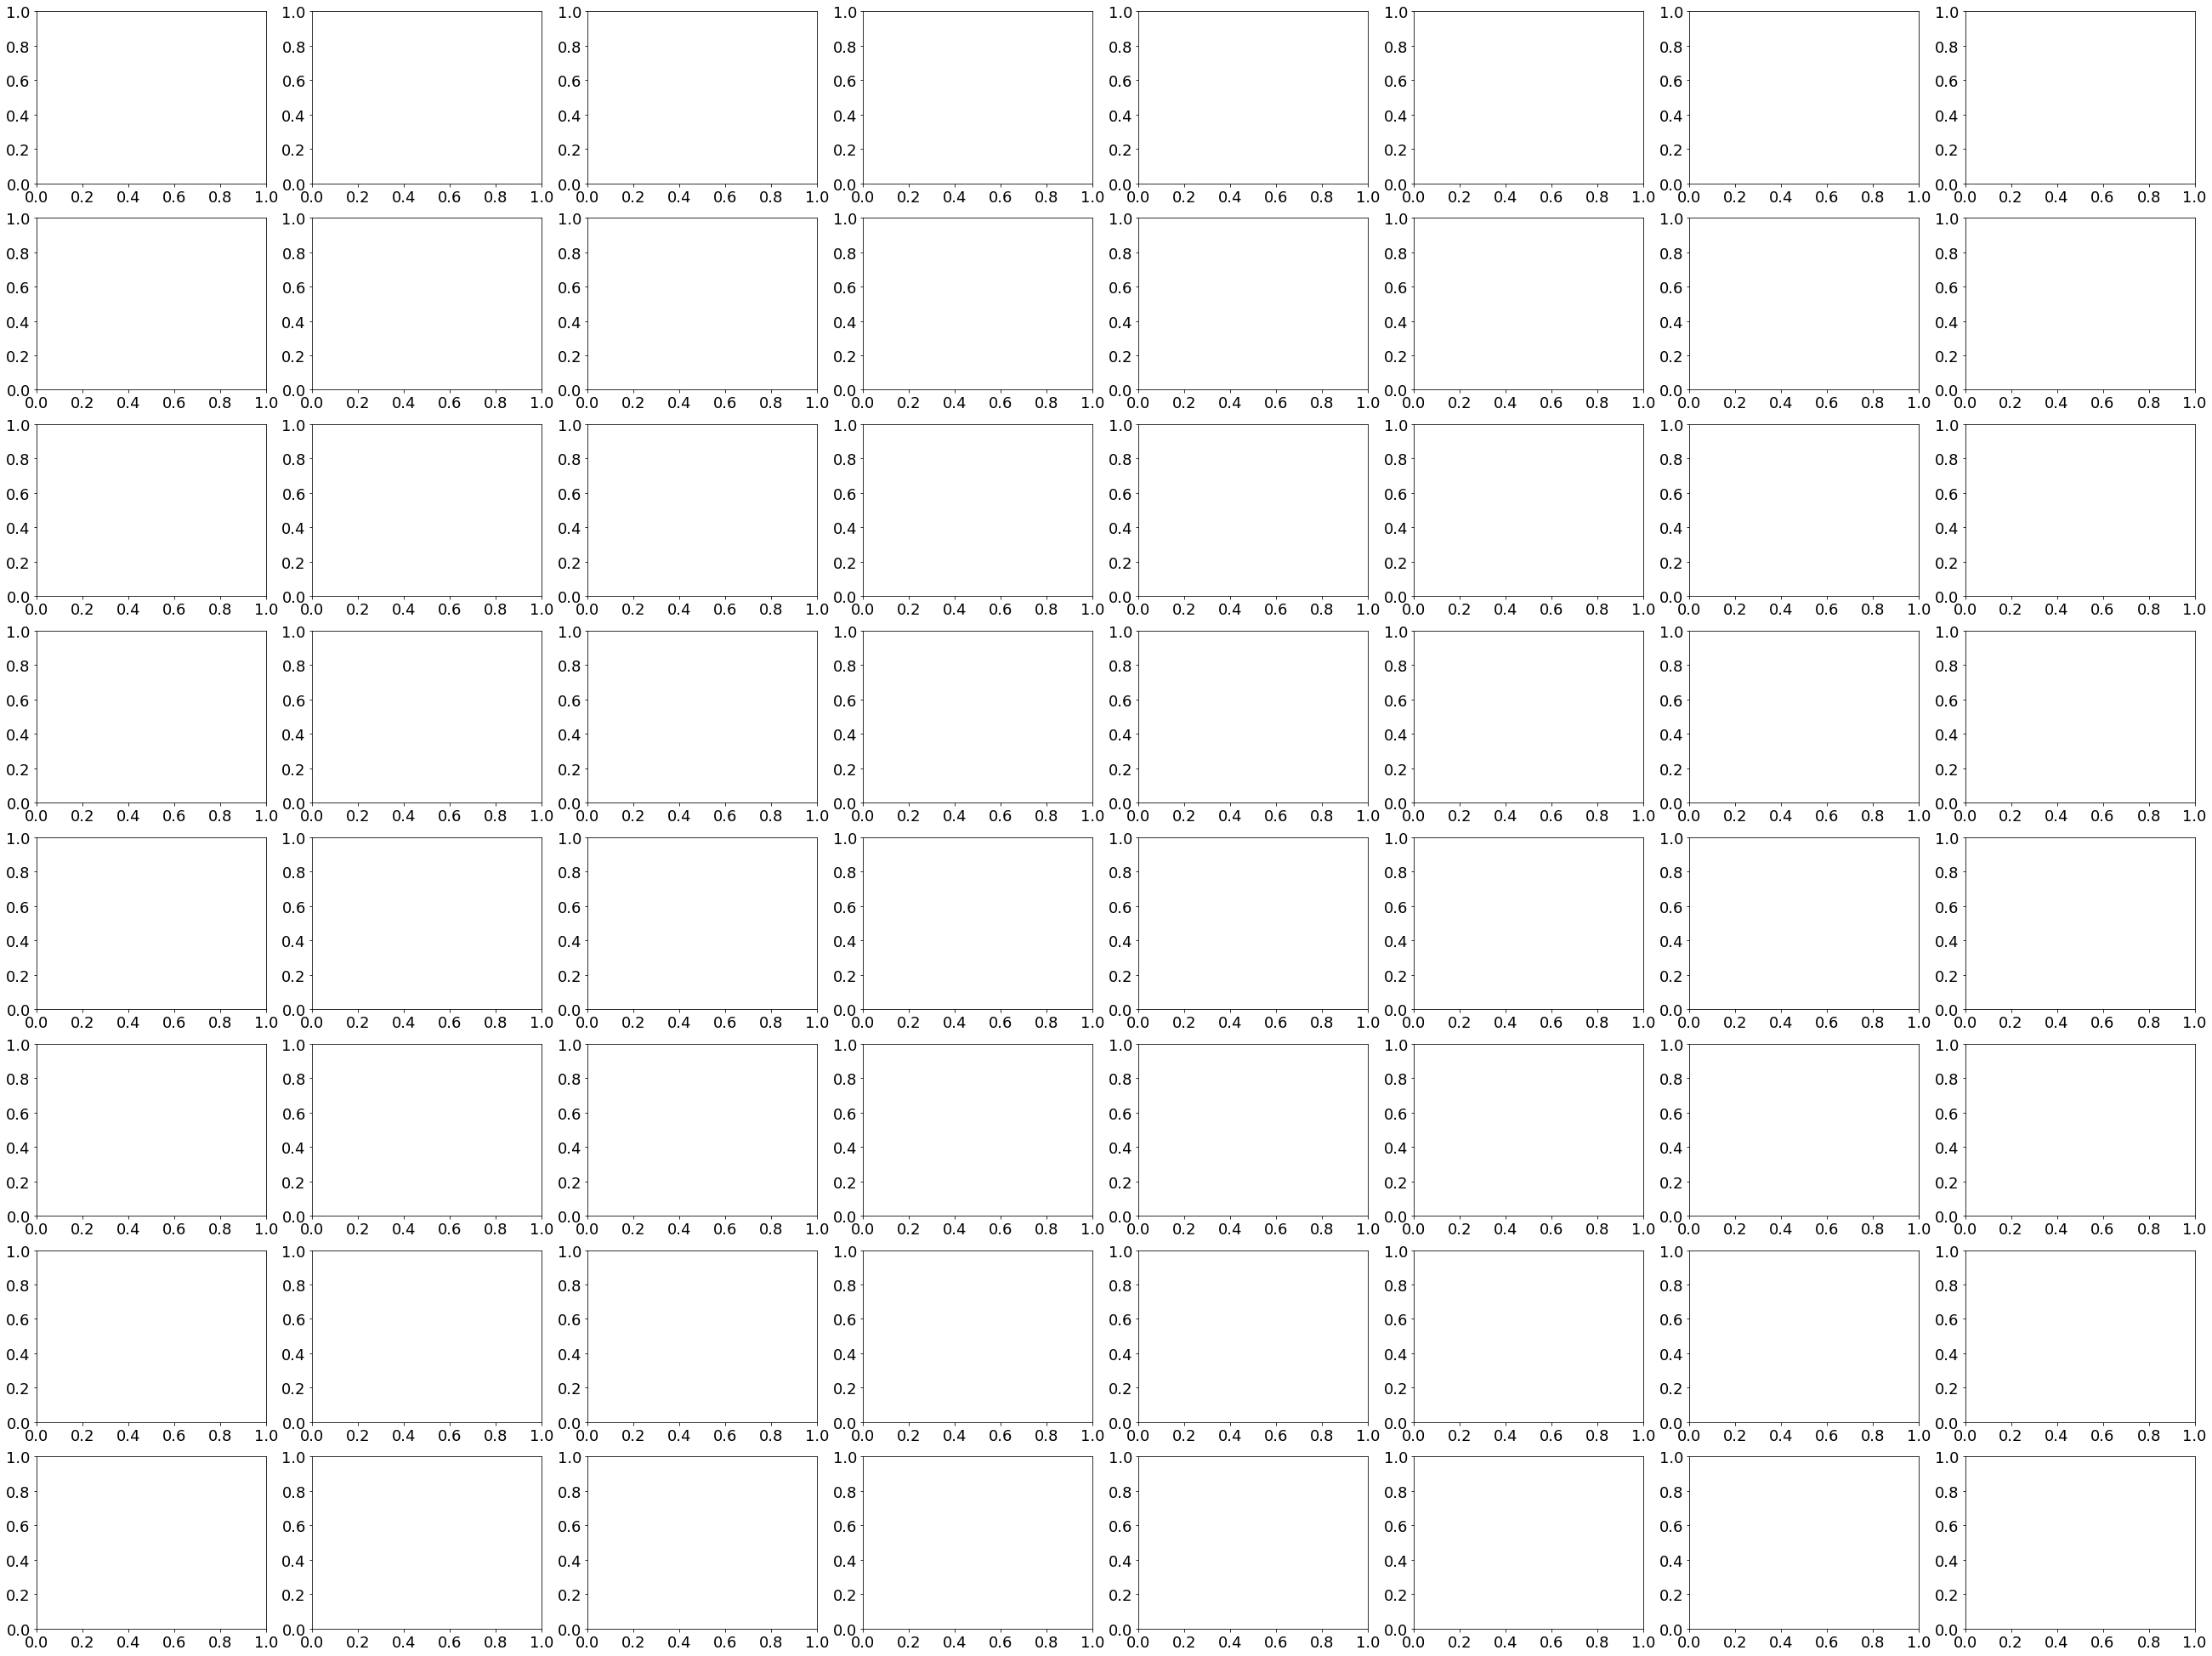

In [32]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_gray_del_lay.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_gray_del_lay.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address, pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_gray_del_lay.loc[idx]['top_1'] == df_gray_del_lay.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_gray_del_lay.loc[idx]['top_1'] + ' | ' + df_gray_del_lay.loc[idx]['model'], color=color)
    likelihood = df_gray_del_lay.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'df_gray_del_lay' is not defined

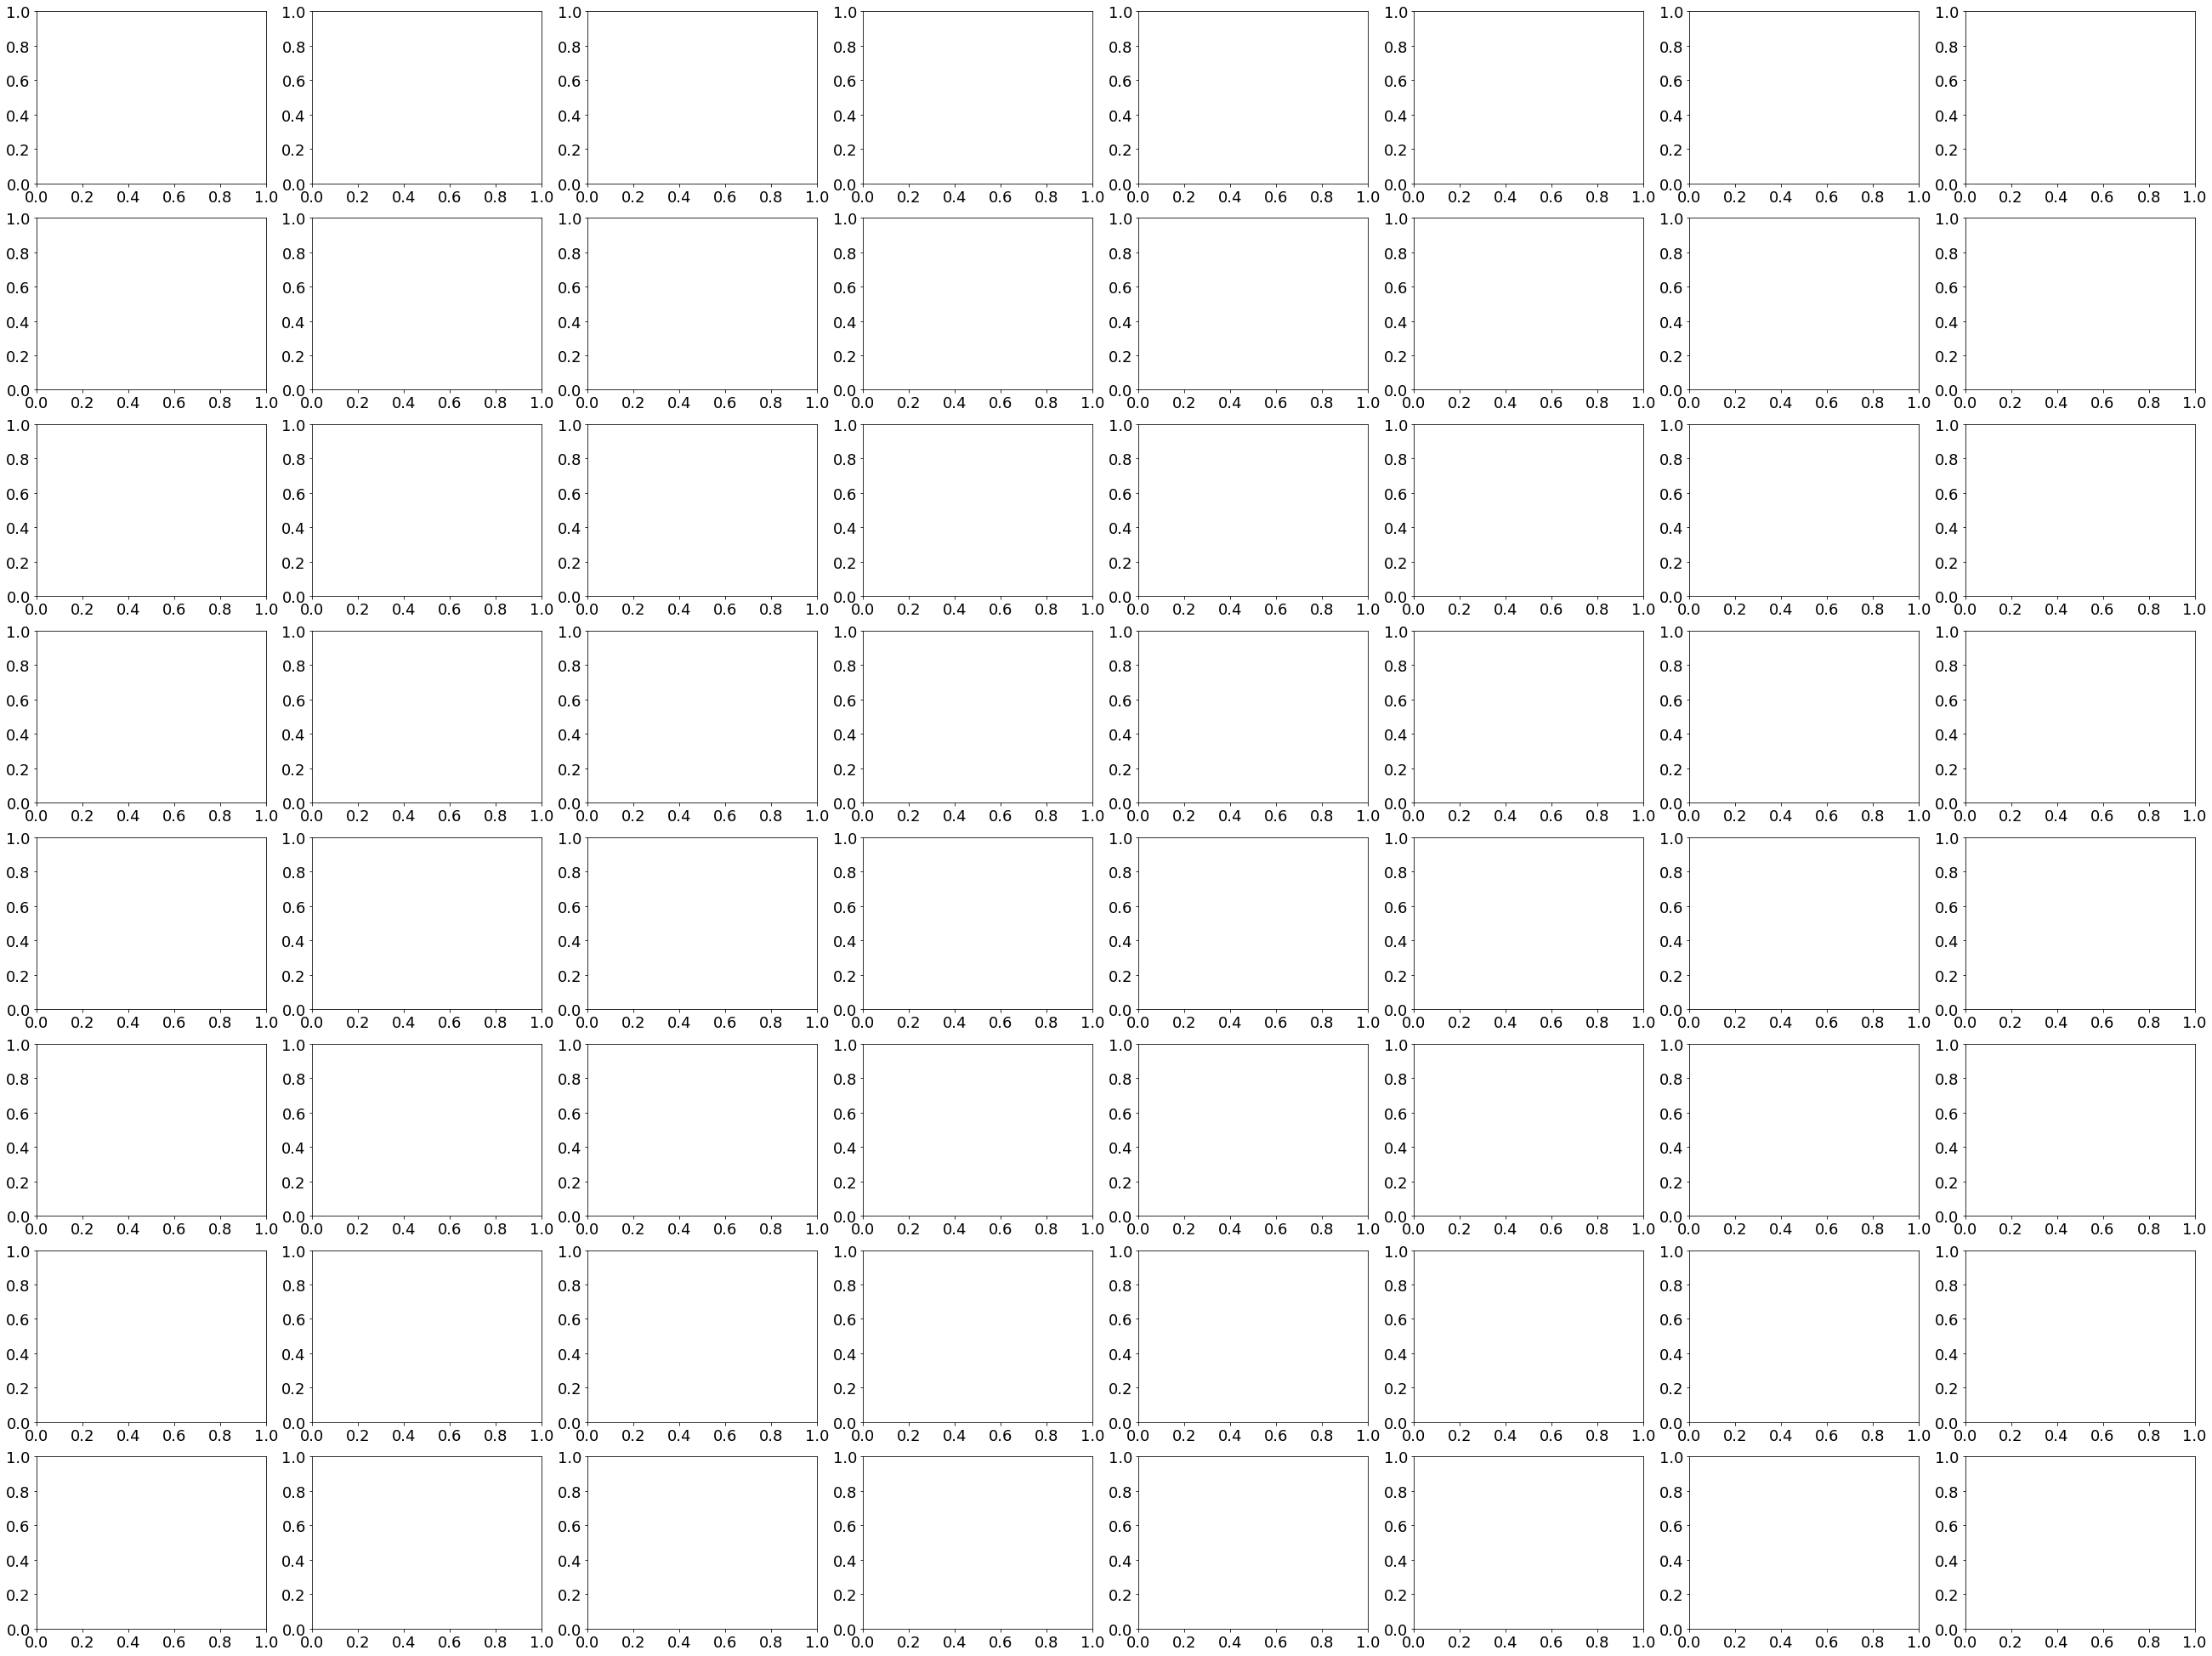

In [33]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_gray_del_lay.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_gray_del_lay.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address, pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_gray_del_lay.loc[idx]['top_1'] == df_gray_del_lay.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_gray_del_lay.loc[idx]['top_1'] + ' | ' + df_gray_del_lay.loc[idx]['model'], color=color)
    likelihood = df_gray_del_lay.loc[idx]['likelihood']
    ax.set_ylabel(df_gray_del_lay.loc[idx]['goal'], color=color)  
fig.set_facecolor(color='white')

### Accuracy

In [34]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig_width = 15
results = []
for name in models_vgg:
    results.append(f1_score(df_gray_del_lay[df_gray_del_lay['model']==name]["goal"],
                            df_gray_del_lay[df_gray_del_lay['model']==name]["top_1"],average='micro'))
df_acc = pd.DataFrame({'': results},index = models_vgg)
ax = df_acc.plot.bar(rot=30, figsize=(fig_width, fig_width//2), fontsize = 18)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
plt.legend(bbox_to_anchor=(1.15, .5), loc='right')
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
ax.set_ylabel('F1 Score', size= 20)
ax.set_xlabel('Models', size= 20)
plt.savefig('Cosyne_fig2.1.pdf')

NameError: name 'models_vgg' is not defined

In [35]:
df_acc = pd.DataFrame({model_name: {label: f1_score(df_[(df_['model']==model_name)]["top_1"], 
                                                               df_[(df_['model']==model_name)]["goal"],
                                                   average='micro')
                                    for label, df_ in zip(['original', 'gray'], [df_del_lay, df_gray_del_lay])} 
                       for model_name in models_vgg})

ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//2), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.15, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 3 - color vs gray images', size=20)
ax.set_ylabel('F1 Score', size=14)
plt.show();

NameError: name 'models_vgg' is not defined

### Computation time
Todo : plot time changer axe abs

In [36]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi/2))
for color, df_, label, legend in zip(['gray', 'red'], [df_gray_del_lay, df_del_lay], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models_vgg.keys()):
        ax.set_ylabel('Frequency', fontsize=20) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper right', fontsize=20)
        ax.set_xlim(df_gray_del_lay['time'].quantile(.01), df_gray_del_lay['time'].quantile(.99))
        ax.legend(bbox_to_anchor=(1.18, .35), loc='lower right')
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df_del_lay['device_type'][0]), size = 20);

NameError: name 'models_vgg' is not defined

### Conclusion

While appliyng a grayscale transformation in the input we compare the performance with the ones from the [experiment 1](#exp1). Indeed all the networks seems robust to this transformation too. Some deepness even have a slightly better accuracy in this conditions (VGG-6, VGG-9 & VGG-10). As in the [experiment 2](#exp2) this may be explain by the complexity obn the features on which these networks rely to categorize the synset of interest in the scene. 

## Experiment 4: Test on Serre_2007 dataset

In [37]:
scriptname = 'Prunning/experiment_serre.py'

In [38]:
%%writefile {scriptname}

#import model's script and set the output file
from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

filename = f'results/{datetag}_results_del_serre_{HOST}.json'
print(f'{filename=}')
serre = ['targets', 'distractors']
paths['animal']['test'] = '/home/INT/jeremie.j/Serre_2007'

# Output's set up
def main():
    if os.path.isfile(filename):
        df_serre = pd.read_json(filename)
    else:
        df_serre = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
        i_trial = 0
        # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        # Displays the input image of the model
        for i_image, (data, label) in enumerate(dataloaders['animal']['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'targets' in image_datasets['animal']['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if likelihood>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_serre.loc[i_trial] = {'model':model_name, 'model_task':model_task, 'likelihood':likelihood, 'time':elapsed_time, 
                                         'fps': 1/elapsed_time, 'goal': goal, 'i_image':i_image, 'top_1':top_1,
                                         'filename':image_datasets['animal']['test'].imgs[i_image][0], 'device':device.type}
                print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : animal, {goal}')
                i_trial += 1
    df_serre.to_json(filename)
main()

Overwriting Prunning/experiment_serre.py


In [39]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

<Figure size 432x288 with 0 Axes>

In [40]:
filename = f'results/{datetag}_results_del_serre_{HOST}.json'
df_serre = pd.read_json(filename)
df_serre

ValueError: Expected object or value

### Accuracy

In [41]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({'accuracy': [accuracy_score(df_serre[df_serre['model']==model_name]["top_1"], df_serre[df_serre['model']==model_name]["goal"]) for model_name in models_vgg.keys()]}, index=models_vgg.keys())
ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
ax.bar_label(ax.containers[0], padding=-24, color='black', fontsize=14, fmt='%.3f')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title('Average accuracy top_1 : for each models - Serre & al 2007 dataset', size=20)
ax.set_xlabel('Model', size=20);

NameError: name 'models_vgg' is not defined

### Todo : image + time process + ccl

## Experiment 5: Image processing and recognition for differents flip transformations

In [42]:
scriptname =  'experiment_flip_anim.py'

In [43]:
%%writefile {scriptname}

#import model's script and set the output file
from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
datetag = '2022-01-11'
flips = {}
flips['Horizontal'] = transforms.RandomHorizontalFlip(p=1)
flips['Vertical'] = transforms.RandomVerticalFlip(p=1)

filename = f'results/{datetag}_results_flip_{args.HOST}.json'
print(f'{filename=}')

def main():
    if os.path.isfile(filename):
        df = pd.read_json(filename)
    else:
        i_trial = 0
        df_flip = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type', 'flip'])   
        # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for flip in flips:
            pprint(flip)
            task = 'animal'
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = flips[flip](data)
                data, label, = data.to(device), label.to(device)
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        model_task = 'animal' if 'animal' in model_name else 'artifact'
                        tic = time.time()
                        out = model(data).squeeze(0)
                        percentage = (torch.sigmoid(out) * 100).detach().cpu().numpy()[0]
                        elapsed_time = time.time() - tic
                        top_1 = 'target' if percentage>50 else 'distractor'
                    df_flip.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                           'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type, 'flip':flip}
                    print(f'The {model_name} model categorize {model_task} with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                    i_trial += 1

        df_flip.to_json(filename)
main()

Overwriting experiment_flip_anim.py


In [44]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

In [45]:
datetag = '2022-01-11'
filename = f'results/{datetag}_results_flip_{args.HOST}.json'
df_flip = pd.read_json(filename)
df_flip

ValueError: Expected object or value

### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'df_flip' is not defined

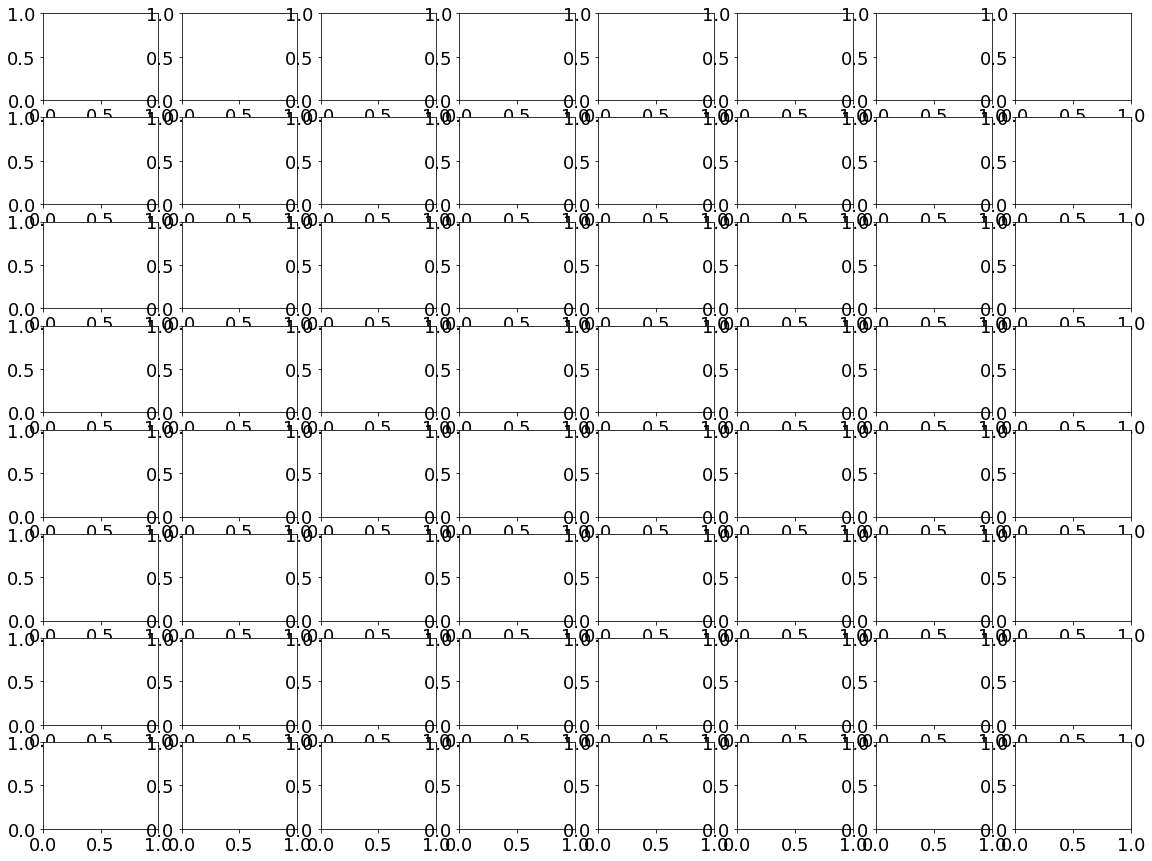

In [46]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_flip.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_flip.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_flip.loc[idx]['top_1'] == df_flip.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_flip.loc[idx]['top_1'] + ' | ' + df_flip.loc[idx]['model'], color=color)
    likelihood = df_flip.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'df_flip' is not defined

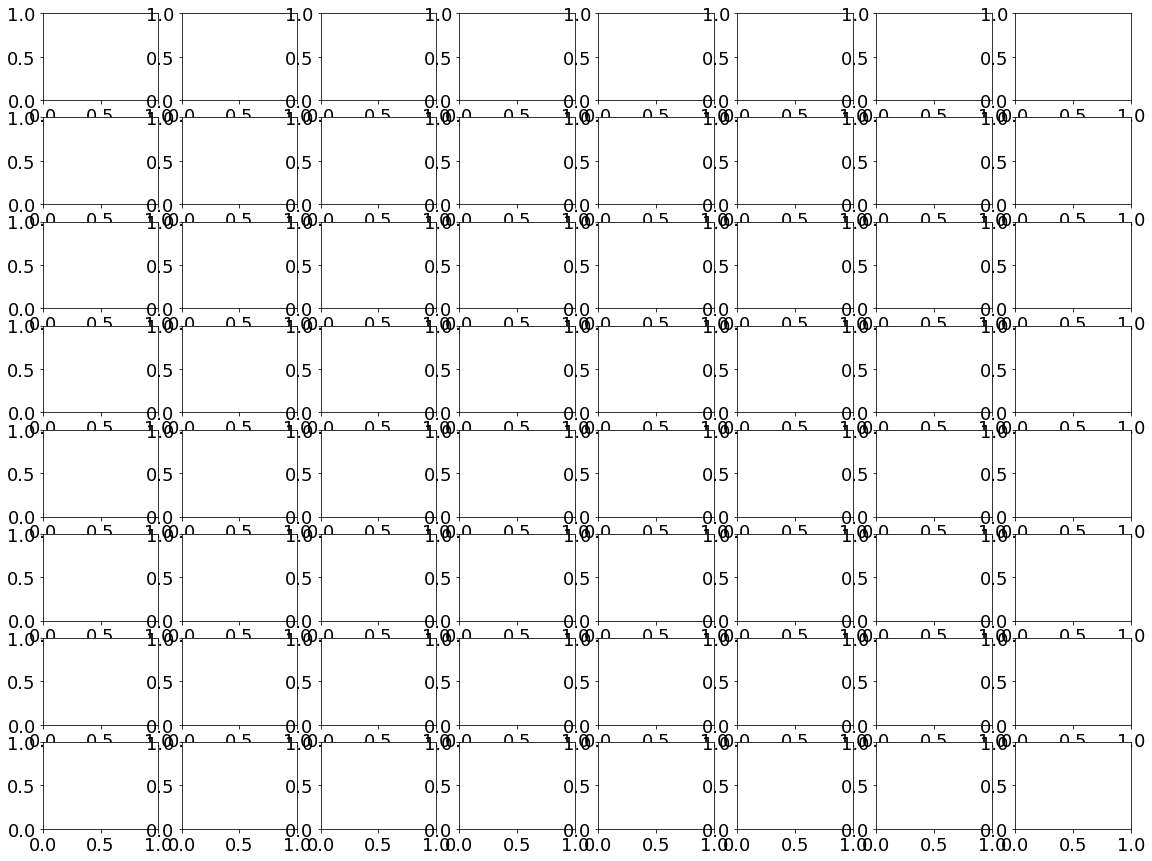

In [47]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_flip.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_flip.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_flip.loc[idx]['top_1'] == df_flip.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_flip.loc[idx]['top_1'] + ' | ' + df_flip.loc[idx]['model'], color=color)
    likelihood = df_flip.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)  
fig.set_facecolor(color='white')

### Accuracy

In [48]:
fig_width = 35
#names_diff = ['vgg16_gen','vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8'] 
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {flip: accuracy_score(df_flip[(df_flip['model']==model_name) & (df_flip['flip']==flip)]["top_1"], 
                                                               df_flip[(df_flip['model']==model_name) & (df_flip['flip']==flip)]["goal"])
                                    for flip in flips} 
                       for model_name in models_vgg})
ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=30)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=18, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.05, .5), loc='center', fontsize=18)
ax.set_ylabel('F1 Score', size=32)
ax.set_xlabel('Flip', size=32)
#plt.show();
plt.savefig('del_lay_diff_size.pdf')

NameError: name 'models_vgg' is not defined

In [49]:
ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 2 - image sizes = {args.image_sizes}', size=20)
#ax.set_xticks([])
ax.set_ylabel('F1 score', size=32)
ax.set_xlabel('Models', size=32)
plt.show();

NameError: name 'df_acc' is not defined

### Todo : time process + ccl

## Experiment 5: Image processing and recognition on rotated images :

In [50]:
scriptname = 'experiment_rotate.py'

In [51]:
%%writefile {scriptname}

#import model's script and set the output file
from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

angles = np.arange(-180, 181)

datetag = '2022-02-11'
filename = f'results/{datetag}_results_rotate_prunning{args.HOST}.json'
print(f'{filename=}')
     

def main():
    if os.path.isfile(filename):
        df_angle = pd.read_json(filename)
    else:
        i_trial = 0
        df_mean = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=50)
        # image preprocessing
        #for task in args.tasks:
        task = 'animal'
        print(task)
        for angle in angles:
            print(f'Rotation by {angle=}°')
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                acc_= 0
                for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                    data, label, = data.to(device), label.to(device)
                    data = transforms.functional.rotate(data, angle=float(angle), expand = True)
                    with torch.no_grad():
                        outputs = model(data)
                        preds = torch.round(torch.sigmoid(outputs[:,0].data))
                        acc_ += torch.sum(preds == label.data)
                avg_acc = acc_ / dataset_sizes[task]['test']
                df_mean.loc[i_trial] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':angle}  
                print(model_name, avg_acc, angle)
                #print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
                torch.cuda.empty_cache()
            df_mean.to_json(filename)
main()

Overwriting experiment_rotate.py


In [52]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

<Figure size 432x288 with 0 Axes>

In [53]:
datetag = '2022-02-11'
filename = f'results/{datetag}_results_rotate_prunning{args.HOST}.json'
df_angle = pd.read_json(filename)
df_angle

ValueError: Expected object or value

### Image display 

Here is the images with the highest likelihood of the networks :

NameError: name 'df_angle' is not defined

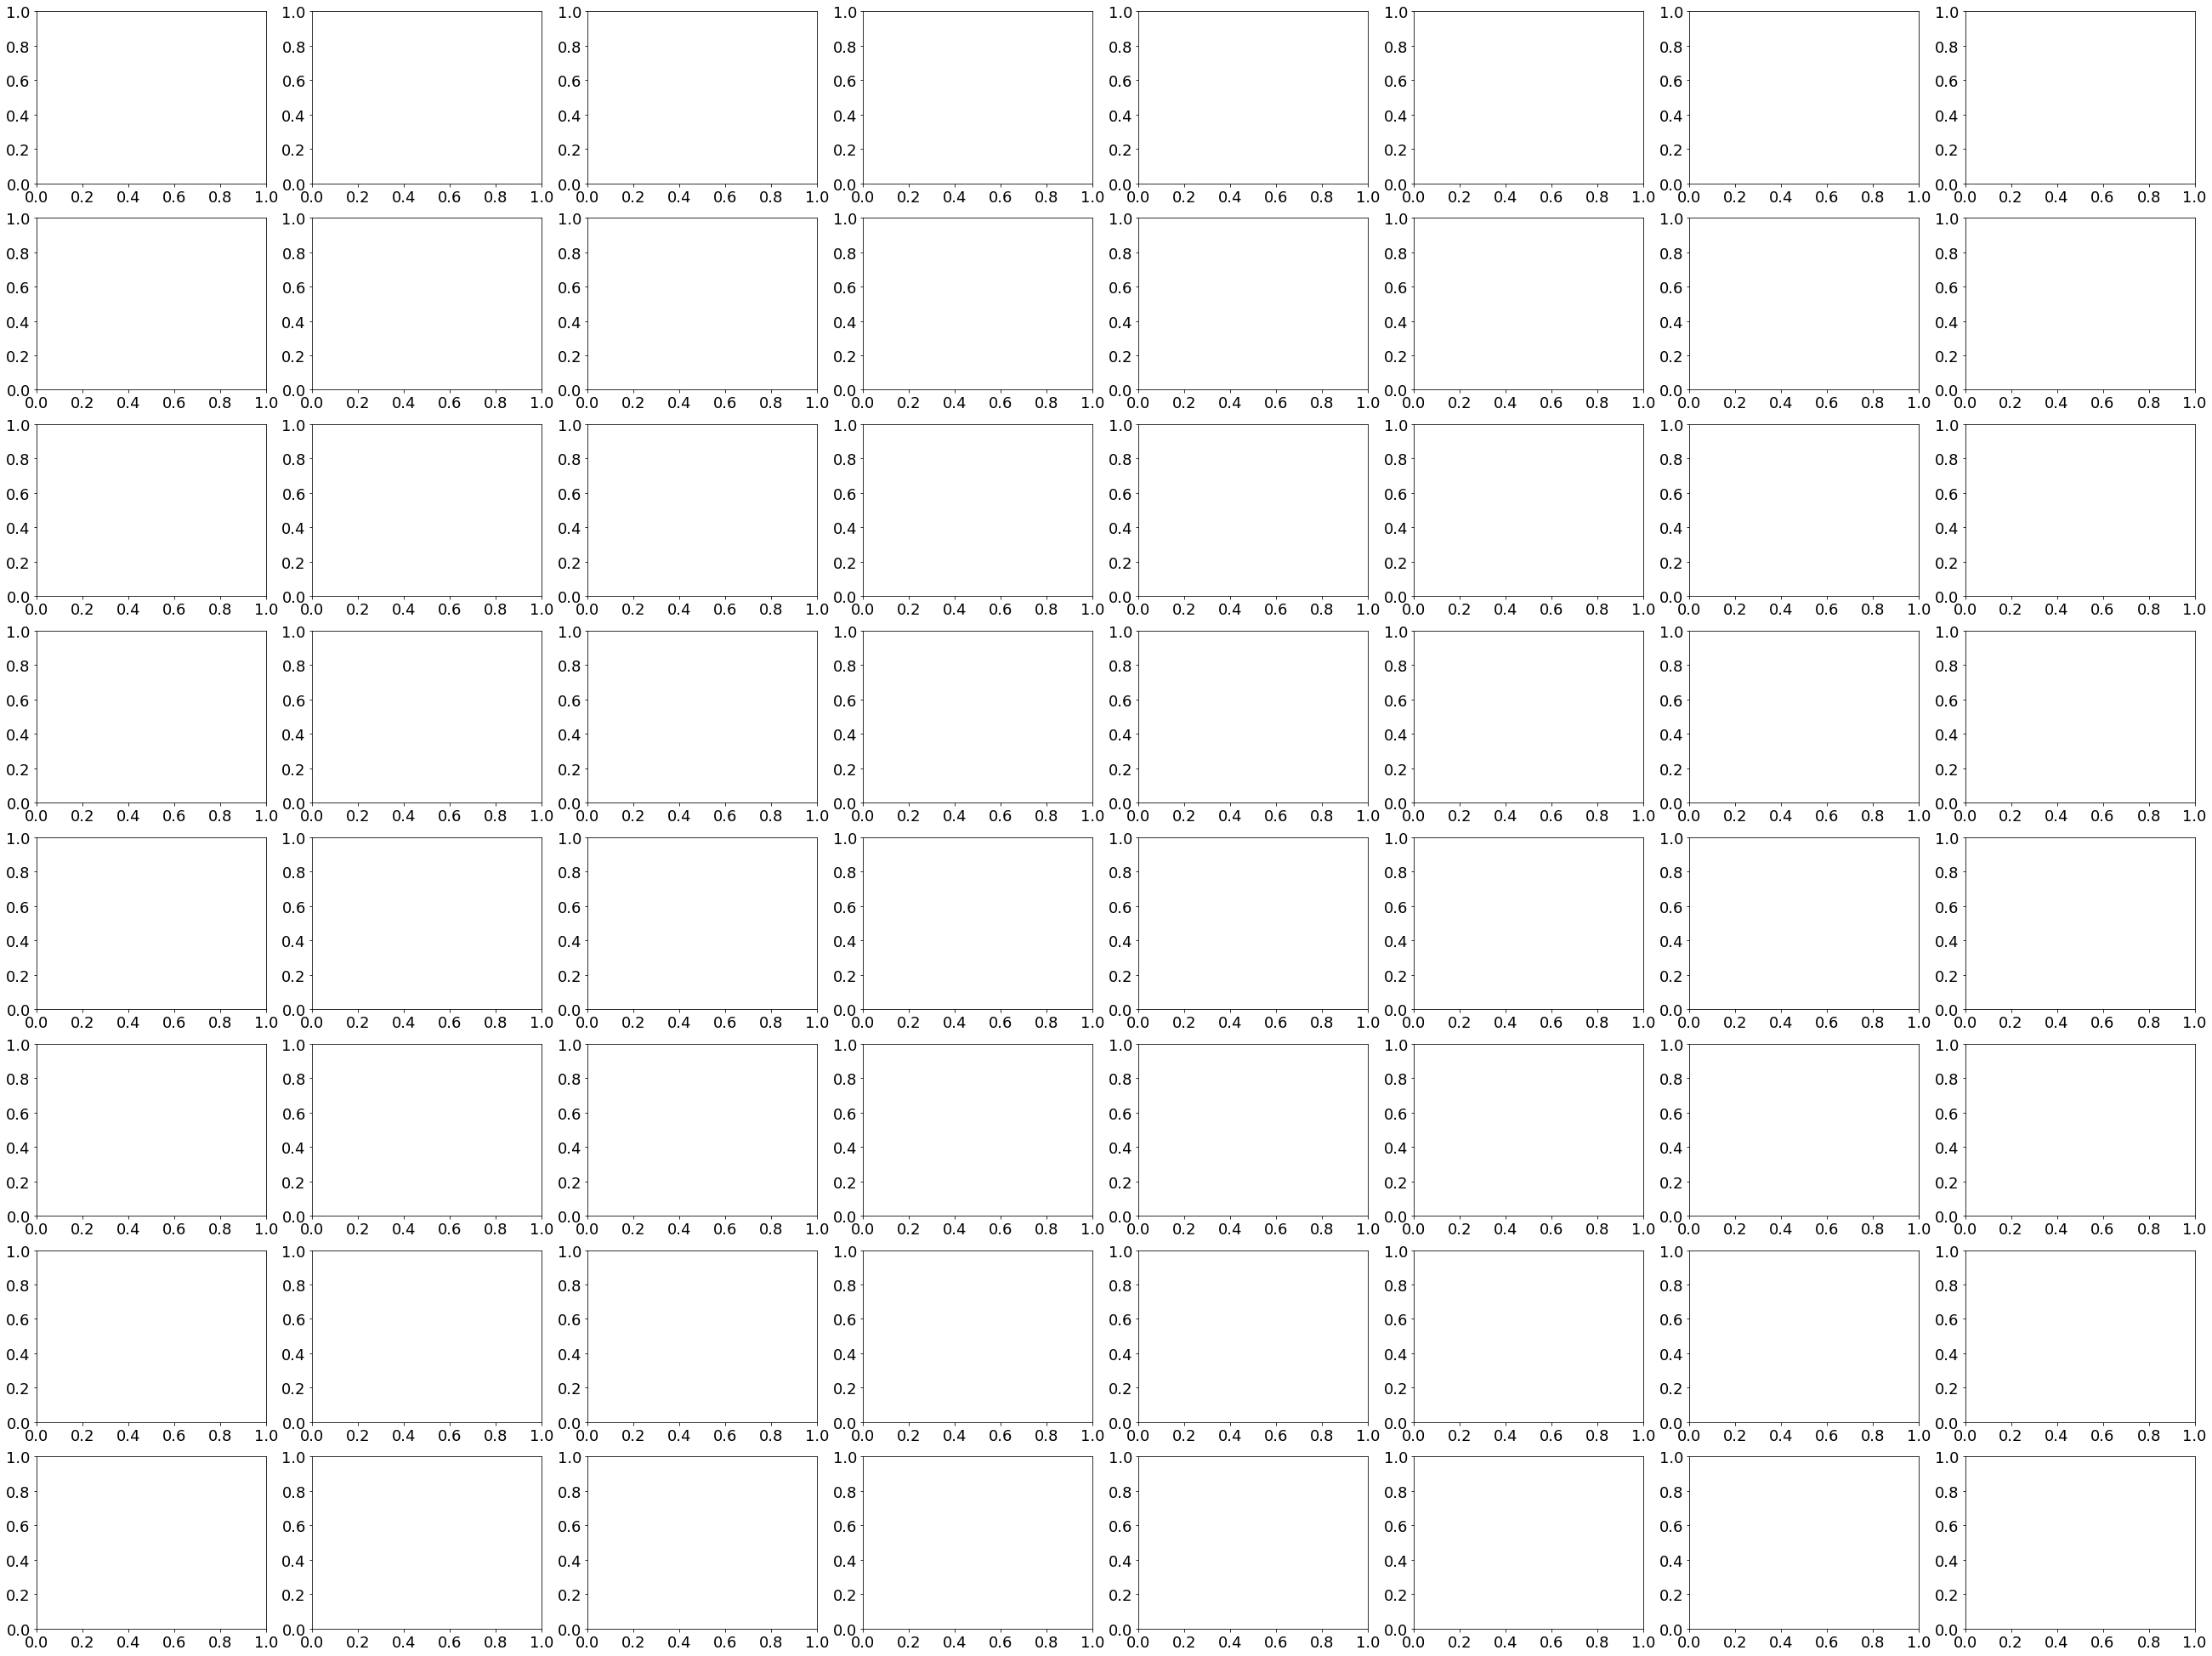

In [54]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_angle.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_angle.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_angle.loc[idx]['top_1'] == df_angle.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_angle.loc[idx]['top_1'] + ' | ' + df_angle.loc[idx]['model'] + ' | ' + str(df_angle.loc[idx]['angle']), color=color)
    likelihood = df_angle.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'df_angle' is not defined

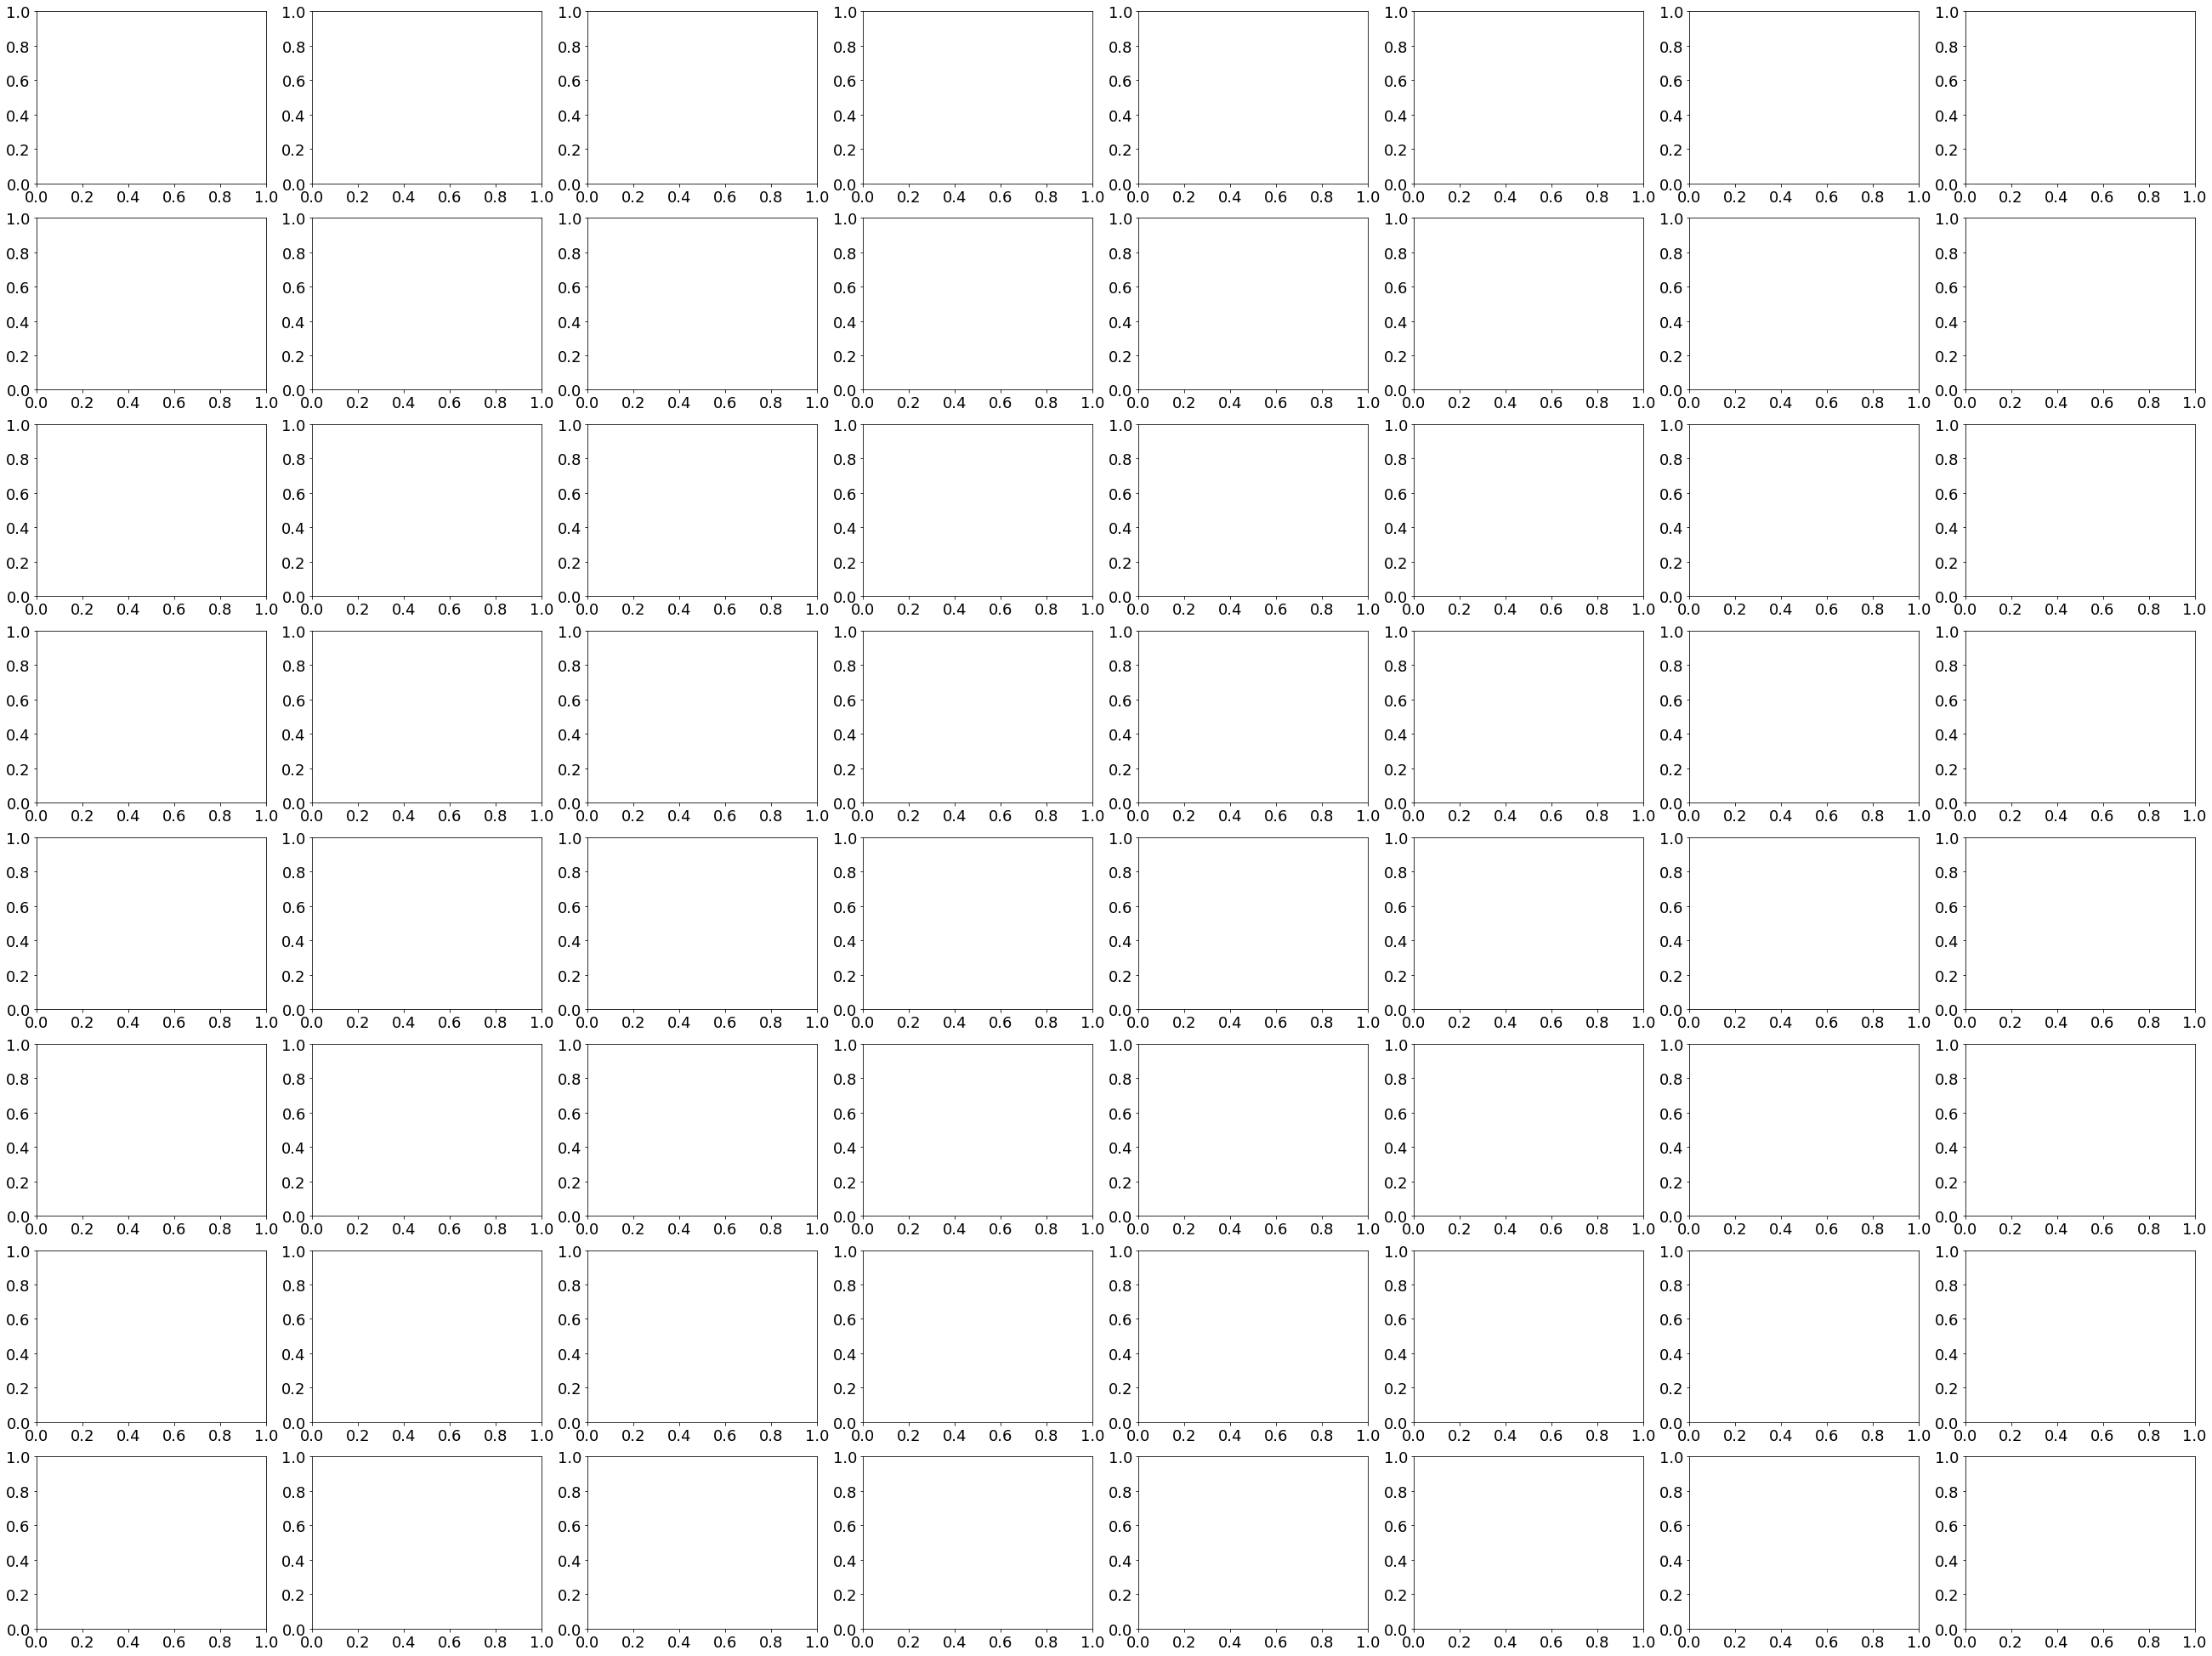

In [55]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_angle.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_angle.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_angle.loc[idx]['top_1'] == df_angle.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_angle.loc[idx]['top_1'] + ' | ' + df_angle.loc[idx]['model'] + ' | ' + str(df_angle.loc[idx]['angle']), color=color)
    likelihood = df_angle.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)  
fig.set_facecolor(color='white')

### Accuracy

NameError: name 'df_angle' is not defined

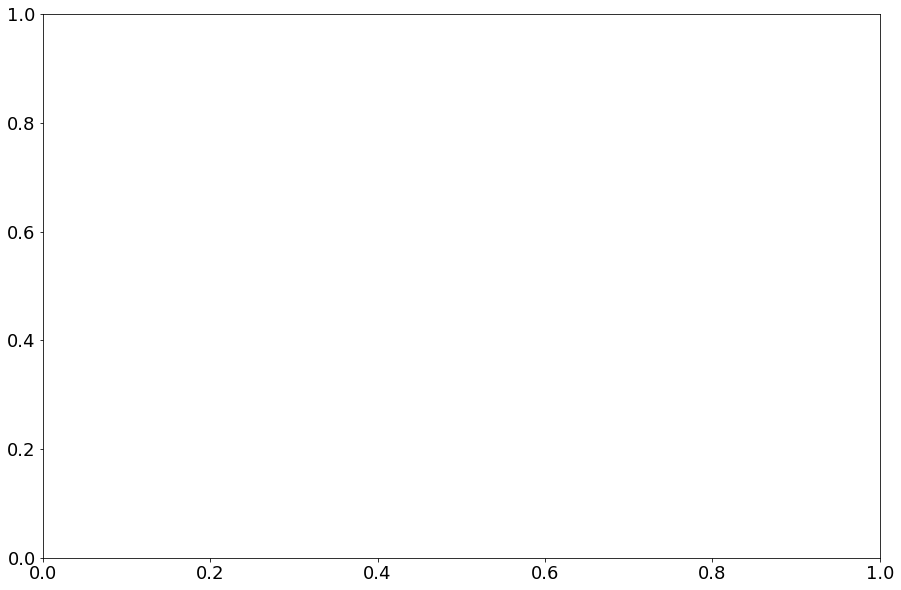

In [56]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
angles = np.arange(-180, 181, 1)
cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})
for model_name in df_angle['model'].unique():     
    df_angle[(df_angle['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                         marker='o', lw=0, label=model_name, ax=ax)
ax.legend(loc='center right', fontsize = 12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim(0, 1)
ax.set_xlim(-185, 185)
#plt.set_cmap('Blues')
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_ylabel('Mean Accuracies', size= 25, fontweight='bold')
ax.set_xlabel('Rotation (°)', size= 25, fontweight='bold')
plt.legend(bbox_to_anchor=(1.11, .5), loc='center', fontsize=20)
plt.tight_layout();
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold');
plt.savefig('IJCNN_fig.7.b.pdf')

In [57]:
import statistics
for name in df_angle['model'].unique():
    data_mean = df_angle.loc[df_angle['model'] == name]
    st_dev = statistics.pstdev(data_mean['mean_prediction'])
    mean =statistics.mean(data_mean['mean_prediction'])
    print("Standard deviation of the given list: " + name + '    ' + str(st_dev*100))
    print("Mean of the given list: " + name  + '    ' + str(mean*100))

NameError: name 'df_angle' is not defined

NameError: name 'df_angle' is not defined

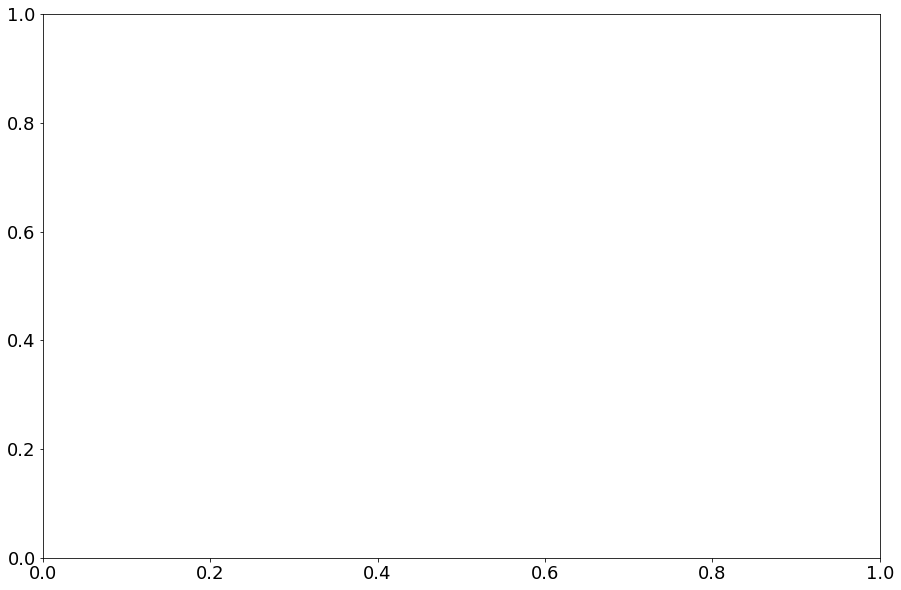

In [58]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.cm.get_cmap('viridis')
angles = np.arange(-180, 181, 1)
color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})
df_mean = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
model_name = 'vgg-4'     
df_angle[(df_angle['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                   alpha=0.5, marker='o', lw=0, label=model_name, ax=ax)
ax.legend(loc='center right', fontsize = 12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(0, 1)
ax.set_xlim(-185, 185)
#plt.set_cmap('Blues')
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_ylabel('Accuracy', size= 16)
ax.set_xlabel('Rotation (°)', size= 16)
plt.legend(bbox_to_anchor=(1.1, .5), loc='center', fontsize=14,)
ax.set_title(' Rotation of the image from 0° angle to 360° angle around the center of the image', size = 20);
plt.tight_layout();

### Computation time

NameError: name 'models_vgg' is not defined

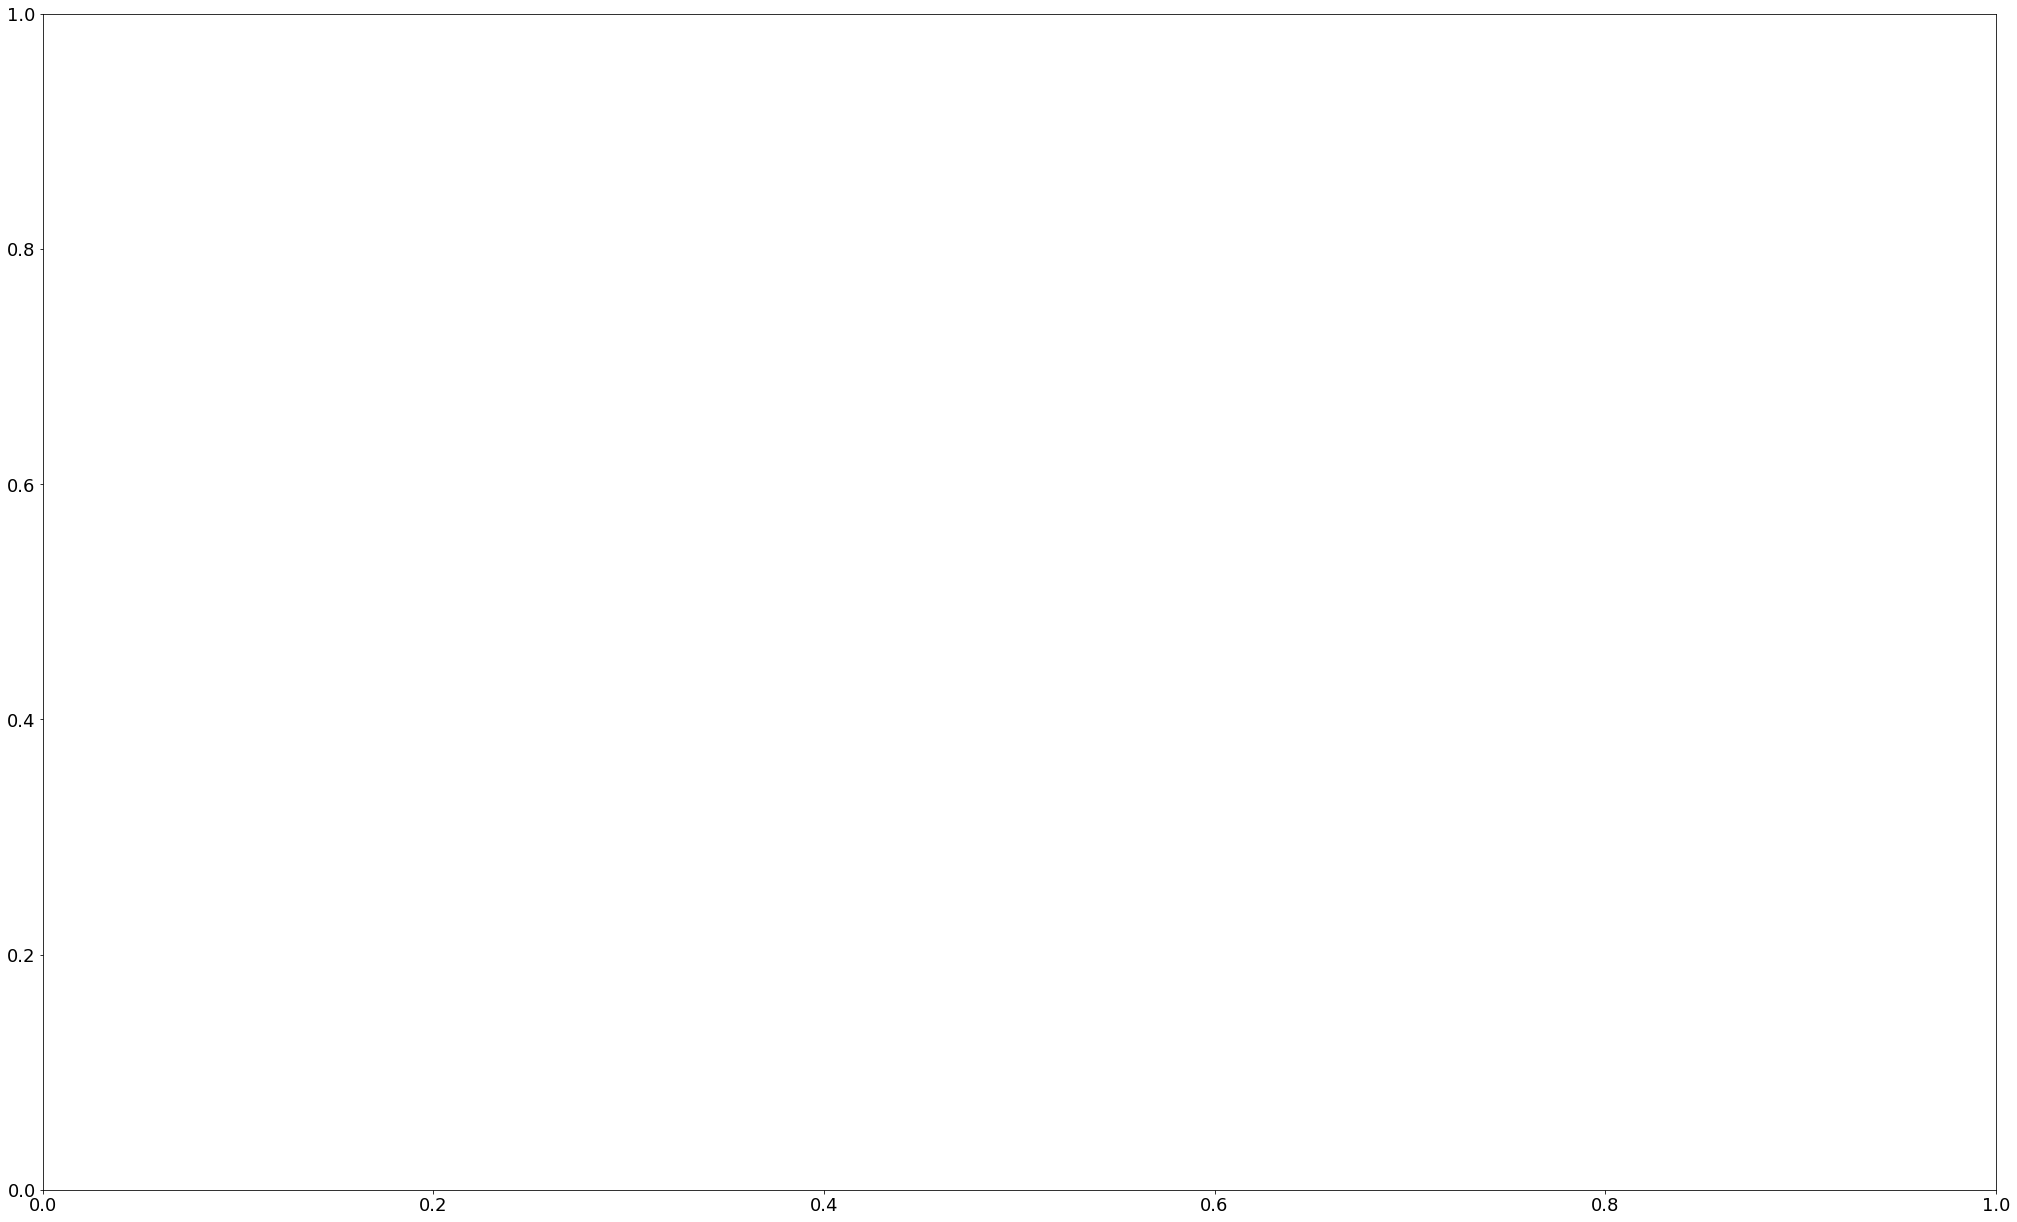

In [59]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="angle", y="time", data=df_angle, inner="quartile", hue='model')
    axs.set_title('Processing time (s) for each network at different image size. Processed on : ' + args.HOST + '_' + str(df_downsample['device_type'][0]), size = 20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Image size', size=18)
    axs.set_yscale('log')
    axs.grid(which='both', axis='y')
    for side in ['top', 'right'] :axs.spines[side].set_visible(False)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

### Todo : time process + ccl

## Experiment 6: Image processing and recognition on shuffled images

In [60]:
scriptname =  'Prunning/experiment_shuffle.py'

In [61]:
%%writefile {scriptname}

#import model's script and set the output file

from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
datetag = '2022-02-09'
filename = f'results/{datetag}_results_1_shuffle_{HOST}.json'
print(f'{filename=}')

task = 'animal'
shuffle_sizes = [256, 128, 64, 32]
def main():
    if os.path.isfile(filename):
        df_shuffle = pd.read_json(filename)
    else:
        i_trial = 0
        df_shuffle = pd.DataFrame([], columns=['model', 'shuffle_size', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        for shuffle_size in shuffle_sizes:
            print(shuffle_size)
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(
                image_size=args.image_size, shuffle=shuffle_size, batch_size=1)
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data, label = data.to(device), label.to(device)
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        tic = time.time()
                        out = model(data).squeeze(0)
                        percentage = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                        top_1 = 'target' if percentage>50 else 'distractor'
                        elapsed_time = time.time() - tic
                    df_shuffle.loc[i_trial] = {'model':model_name, 'shuffle_size':shuffle_size, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                          'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                    #print(f'The {model_name} model categorize an animal with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                    i_trial += 1
                    torch.cuda.empty_cache()
    df_shuffle.to_json(filename)
main()         

Overwriting Prunning/experiment_shuffle.py


In [62]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

<Figure size 432x288 with 0 Axes>

In [63]:
datetag = '2022-02-09'
filename = f'results/{datetag}_results_1_shuffle_{HOST}.json'
df_shuffle = pd.read_json(filename)
df_shuffle

ValueError: Expected object or value

### Accuracy

In [64]:
fig_width = 35
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {shuffle_size: accuracy_score(df_shuffle[(df_shuffle['model']==model_name) & (df_shuffle['shuffle_size']==shuffle_size)]["top_1"], 
                                                               df_shuffle[(df_shuffle['model']==model_name) & (df_shuffle['shuffle_size']==shuffle_size)]["goal"])
                                    for shuffle_size in shuffle_sizes} 
                       for model_name in models_vgg})

ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=30)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=18, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.05, .5), loc='center', fontsize=18)
#ax.set_title(f'Experiment 2 - image sizes = {args.image_sizes}', size=20)
ax.set_ylabel('F1 Score', size=32)
ax.set_xlabel('Shuffle size', size=32)
#plt.show();
#plt.savefig('del_lay_diff_size.pdf')

NameError: name 'models_vgg' is not defined

In [65]:

cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_acc)) for i,k in enumerate(df_acc)})
ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width/1.2, fig_width//6), fontsize=22, color=color_dict)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='white', fontsize=14, fmt='%.3f', rotation=90, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, .3), fontsize=16, loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
#ax.set_xticks([])
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold')
plt.tight_layout();
plt.savefig('IJCNN_fig.7.c.pdf')

NameError: name 'df_acc' is not defined

NameError: name 'df_shuffle' is not defined

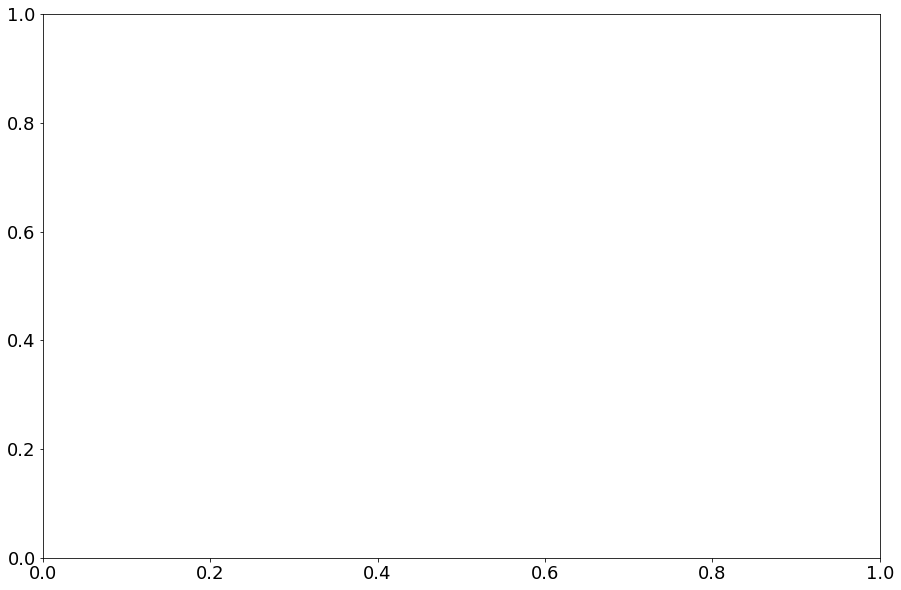

In [66]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
#shuffle_sizes = [32, 64, 128, 256]
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_shuffle['model'].unique())) for i,k in enumerate(df_shuffle['model'].unique())})
df_mean = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
diff_ = np.arange(0, 28, 1)
shuffle_sizes = [256, 128, 64, 32]
for i, model_name in enumerate(df_shuffle['model'].unique()):
    df_mean = pd.DataFrame([], columns=[' ', 'model', '  '])
    for j, shuffle_size in enumerate(shuffle_sizes):
        if i%2 ==1:
            diff_[i]=-diff_[i]
        accuracy = accuracy_score(df_shuffle[(df_shuffle['model']==model_name) & (df_shuffle['shuffle_size']==shuffle_size)]["top_1"], 
                                                               df_shuffle[(df_shuffle['model']==model_name) & (df_shuffle['shuffle_size']==shuffle_size)]["goal"])
        df_mean.loc[j] = {'model':model_name, ' ':accuracy, '  ':shuffle_size - diff_[i]}      
    df_mean[(df_mean['model']==model_name)].plot.scatter(x="  ", y=" ", c=[color_dict[model_name],],
                                                         alpha=0.9, marker=(i+2, 1, 0), s=350, lw=0, label=model_name, ax=ax) # marker=(i, style, angle), s=50
ax.legend(loc='center right', fontsize = 12)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.hlines(xmin=0, xmax=shuffle_sizes[0]+diff_[-1], y=1/2, ls='--', ec='k', label='chance level')
ax.set_xticks(shuffle_sizes)
ax.set_ylim(0.45, 1)
#ax.set_xscale("log")
ax.set_ylabel('Accuracy', size= 24, fontweight='bold' )
plt.legend(bbox_to_anchor=(1.13, .5), loc='center', fontsize=18)
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold')
plt.xticks(shuffle_sizes)
plt.tight_layout()
plt.savefig('IJCNN_fig.10.pdf');

### Todo : Image + time + remake last accuracy graph + CCl

# Variation on the performances with different synsets complexity

## Cat

In [67]:
scriptname =  'Prunning/experiment_cat.py'

In [68]:
%%writefile {scriptname}

#import model's script and set the output file

from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_1_cat_{HOST}.json'
print(f'{filename=}')

task = 'cat'

def main():
    if os.path.isfile(filename):
        df_cat = pd.read_json(filename)
    else:
        i_trial = 0
        df_cat = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    percentage = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if percentage>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_cat.loc[i_trial] = {'model':model_name, 'model_task':task, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                      'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize an animal with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
    df_cat.to_json(filename)
main()         

Overwriting Prunning/experiment_cat.py


In [69]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

<Figure size 432x288 with 0 Axes>

In [70]:
filename = f'results/{datetag}_results_1_cat_{HOST}.json'
df_cat = pd.read_json(filename)
df_cat

ValueError: Expected object or value

### Accuracy

## Dog

In [71]:
scriptname =  'Prunning/experiment_dog.py'

In [72]:
%%writefile {scriptname}

#import model's script and set the output file

from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_1_dog_{HOST}.json'
print(f'{filename=}')

task = 'dog'

def main():
    if os.path.isfile(filename):
        df_dog = pd.read_json(filename)
    else:
        i_trial = 0
        df_dog = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    percentage = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if percentage>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_dog.loc[i_trial] = {'model':model_name, 'model_task':task, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                      'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize an animal with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
    df_dog.to_json(filename)
main()         

Overwriting Prunning/experiment_dog.py


In [73]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

In [74]:
datetag = '2022-01-31'
filename = f'results/{datetag}_results_1_dog_{HOST}.json'
df_dog = pd.read_json(filename)
df_dog

ValueError: Expected object or value

### Accuracy

## Bird

In [75]:
scriptname =  'Prunning/experiment_bird.py'

In [76]:
%%writefile {scriptname}

#import model's script and set the output file

from Prunning.experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_1_bird_{HOST}.json'
print(f'{filename=}')

task = 'bird'

def main():
    if os.path.isfile(filename):
        df_bird = pd.read_json(filename)
    else:
        i_trial = 0
        df_bird = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    percentage = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if percentage>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_bird.loc[i_trial] = {'model':model_name, 'model_task':task, 'top_1':top_1, 'goal':goal, 'likelihood':percentage, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                      'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize an animal with {percentage:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
    df_bird.to_json(filename)
main()         

Overwriting Prunning/experiment_bird.py


In [77]:
%run {scriptname}

ModuleNotFoundError: No module named 'Prunning.vgg_maker'

In [78]:
filename = f'results/{datetag}_results_1_bird_{HOST}.json'
df_bird = pd.read_json(filename)
df_bird

ValueError: Expected object or value

### Accuracy

## Comparison between different synsets

### Accuracy

In [79]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {label: f1_score(df_[(df_['model']==model_name)]["top_1"], 
                                                               df_[(df_['model']==model_name)]["goal"],
                                                   average='micro')
                                    for label, df_ in zip(['animal', 'bird', 'dog', 'cat'], [df_del_lay, df_bird, df_dog, df_cat,])} 
                       for model_name in models_vgg})

ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//2), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.15, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 3 - color vs gray images', size=20)
ax.set_ylabel('F1 Score', size=14)
plt.show();

NameError: name 'models_vgg' is not defined

### Todo : time + CCl

# Bonus : Why can't we use the the pre-trained VGG network trained on the [Imagenet](http://image-net.org/) dataset ?

In [80]:
scriptname =  'Prunning/bonus_vgg16.py'

In [81]:
%%writefile {scriptname}

#import model's script and set the output file

from  src.model import *
from PIL import ImageFile
import math
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_bonus_vgg16_{HOST}.json'
print(f'{filename=}')

task = 'animal'

match = []
class_loader = 'imagenet_label_to_wordnet_synset.json'
with open(class_loader, 'r') as fp: 
    imagenet = json.load(fp)
for a, img_id in enumerate(imagenet):
    labels.append(imagenet[img_id]['label'])
    syn_ = wn.synset_from_pos_and_offset('n', int(imagenet[img_id]['id'].replace('-n','')))
    sem_ = syn_.hypernym_paths()[0]
    for i in np.arange(len(sem_)):
        if task in sem_[i].lemmas()[0].name() :
            match.append(a)
models_vgg = {}    
model_filenames = {}    
models_vgg['VGG_Gen'] = torchvision.models.vgg16(pretrained=True)
m = 0
input_lin_1 = 12544
vgg_head = torchvision.models.vgg16(pretrained=True)
all_models = ['vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']
goal =  list(vgg_head.features.children())
for model_name in all_models:
    model_filenames[model_name] = str(args.model_path +model_name+'.pt')
    models_vgg[model_name] = torchvision.models.vgg16(pretrained=True)
    if len(goal) > 28 :
        del goal[24:26] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal) #get the new features parameters in the model
    elif len(goal) > 26:
        del goal[24:26] # remove the three last Conv2d and ReLU layers
        del goal[-1] # remove the last MaxPool2d layer when no Conv2d or ReLU layer left
        models_vgg[model_name].features = torch.nn.Sequential(*goal) 
    elif len(goal) > 20: # same as above for the next three Conv2d and ReLU layers
        del goal[19:21] 
        models_vgg[model_name].features = torch.nn.Sequential(*goal) 
    elif len(goal) > 17:
        del goal[17:19] # remove the three last Conv2d and ReLU layers
        del goal[-1] # remove the last MaxPool2d layer when no Conv2d or ReLU layer left
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal) > 13:
        del goal[11:13] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal) > 10:
        del goal[10:12] # remove the three last Conv2d and ReLU layers
        del goal[-1] # remove the last MaxPool2d layer when no Conv2d or ReLU layer left
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal)>9:
        del goal[6:8] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    elif len(goal)>7:
        del goal[3:6] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
    else:
        del goal[2:4] # remove the three last Conv2d and ReLU layers
        models_vgg[model_name].features = torch.nn.Sequential(*goal)
        
        
    if model_name in ['vgg-6','vgg-7','vgg-8']:   
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children())
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1, num_features)) # Add your custom input layer
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-9','vgg-10']:
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children()) # Remove last layer
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//2, num_features)) # Add your custom input layer
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-11','vgg-12']:
        num_features = models_vgg[model_name].classifier[6].in_features
        features = list(models_vgg[model_name].classifier.children()) # Remove last layer
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//4, num_features)) # Add your custom input layer
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1

    else :     
        m += 1
        
def main():
    if os.path.isfile(filename):
        test = pd.read_json(filename)
    else:
        i_trial = 0
        test = pd.DataFrame([], columns=['model', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        pprint('GO!')
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name  in models_vgg:
                model = models_vgg[model_name].to(device)
                temp_, likelihood = 0, 0
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    percentage = torch.nn.functional.softmax(out, dim=0) * 100
                    for idx in np.arange(0,1000,1):
                        if idx in match:
                            likelihood += math.exp(percentage[idx].item())
                        else:
                            temp_ += math.exp(percentage[idx].item())  
                    likelihood = likelihood/temp_
                    top_1= 'target' if likelihood>50 else 'distractor' 
                    elapsed_time = time.time() - tic
                test.loc[i_trial] = {'model':model_name, 'likelihood':likelihood, 'top_1':top_1, 'goal':goal, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                      'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize an animal with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                i_trial += 1
    test.to_json(filename)
main()  

Overwriting Prunning/bonus_vgg16.py


In [82]:
%run {scriptname}

filename='results/2022-05-17_results_bonus_vgg16_neo-ope-de04.json'
---
GO!
---
The VGG_Gen model categorize an animal with 0.000 % likelihood (distractor) in 0.053 seconds, groundtrue : animal, distractor
The vgg-1 model categorize an animal with 0.429 % likelihood (distractor) in 0.049 seconds, groundtrue : animal, distractor
The vgg-2 model categorize an animal with 0.601 % likelihood (distractor) in 0.049 seconds, groundtrue : animal, distractor
The vgg-3 model categorize an animal with 0.584 % likelihood (distractor) in 0.049 seconds, groundtrue : animal, distractor
The vgg-4 model categorize an animal with 0.683 % likelihood (distractor) in 0.048 seconds, groundtrue : animal, distractor
The vgg-5 model categorize an animal with 0.099 % likelihood (distractor) in 0.047 seconds, groundtrue : animal, distractor
The vgg-6 model categorize an animal with 0.662 % likelihood (distractor) in 0.047 seconds, groundtrue : animal, distractor
The vgg-7 model categorize an animal with 0.661 % 

In [83]:
filename = f'results/{datetag}_results_bonus_vgg16_{HOST}.json'
results_bonus_vgg16 = pd.read_json(filename)
results_bonus_vgg16

,model,goal,likelihood,fps,time,i_image,filename,top_1,device_type
0,VGG_Gen,distractor,3.344783e-35,19.017647,0.052583,0,../data/animal/test/distractor/0002fadb7d02ae0...,distractor,cuda
1,vgg-1,distractor,4.285745e-01,20.236529,0.049416,0,../data/animal/test/distractor/0002fadb7d02ae0...,distractor,cuda
2,vgg-2,distractor,6.012726e-01,20.323308,0.049205,0,../data/animal/test/distractor/0002fadb7d02ae0...,distractor,cuda
3,vgg-3,distractor,5.836884e-01,20.362577,0.049110,0,../data/animal/test/distractor/0002fadb7d02ae0...,distractor,cuda
4,vgg-4,distractor,6.826634e-01,20.960935,0.047708,0,../data/animal/test/distractor/0002fadb7d02ae0...,distractor,cuda
...,...,...,...,...,...,...,...,...,...
15595,vgg-8,target,6.582767e-01,18.544508,0.053924,1199,../data/animal/test/target/fe7a1a5613e0aee0731...,distractor,cuda
15596,vgg-9,target,6.609767e-01,18.765453,0.053289,1199,../data/animal/test/target/fe7a1a5613e0aee0731...,distractor,cuda
15597,vgg-10,target,6.595584e-01,18.560099,0.053879,1199,../data/animal/test/target/fe7a1a5613e0aee0731...,distractor,cuda
15598,vgg-11,target,6.616327e-01,18.897262,0.052918,1199,../data/animal/test/target/fe7a1a5613e0aee0731...,distractor,cuda


## Accuracy

In [84]:
df_acc = pd.DataFrame({model_name: {label: f1_score(df_[(df_['model']==model_name)]["top_1"], 
                                                               df_[(df_['model']==model_name)]["goal"],
                                                   average='micro')
                                    for label, df_ in zip(['re-train', 'pytorch'], [df_del_lay, results_bonus_vgg16])} 
                       for model_name in models_vgg})

ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//2), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.15, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 3 - color vs gray images', size=20)
ax.set_ylabel('F1 Score', size=14)
plt.show();

NameError: name 'df_del_lay' is not defined